In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.2 MB/s eta 0:00:00


In [ ]:
import torchcodec

In [ ]:
import os, shutil

In [ ]:
!pip -q install torchcodec


In [ ]:
import os, glob, json, math, random, shutil
import numpy as np
import pandas as pd


VIDEO_DIR = "/content/BEAT_video"

LABELS_CSV = "/content/BEAT_video/labels.csv"


OUT_DIR = "/content/BEAT_videot"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_NPZ = os.path.join(OUT_DIR, "beat_video_windows.npz")
print("VIDEO_DIR:", VIDEO_DIR)
print("OUT_NPZ:", OUT_NPZ)

VIDEO_DIR: /content/BEAT_video
OUT_NPZ: /content/BEAT_videot/beat_video_windows.npz


In [ ]:


OUT_DIR = "/content/BEAT_videom"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_NPZ = os.path.join(OUT_DIR, "beat_video_windows.npz")
print("VIDEO_DIR:", VIDEO_DIR)
print("OUT_NPZ:", OUT_NPZ)

VIDEO_DIR: /content/BEAT_video
OUT_NPZ: /content/BEAT_videom/beat_video_windows.npz


In [ ]:
TARGET_FPS = 10
resize_width = 256
model_complexity = 0
MAX_SEC_PER_VIDEO = 30

WIN_SEC = 4.0
STR_SEC = 2.0
T_WIN = int(WIN_SEC * TARGET_FPS)  # 40
T_STR = int(STR_SEC * TARGET_FPS)
MAX_VIDEOS = 50

In [ ]:
videos = sorted(glob.glob(os.path.join(VIDEO_DIR, "**", "*.mp4"), recursive=True))
if len(videos) == 0:
    raise RuntimeError("Не нашёл mp4. Проверь VIDEO_DIR.")
videos = videos[:MAX_VIDEOS]
print("Found videos:", len(videos))
print("Example:", videos[0])


Found videos: 50
Example: /content/BEAT_video/00000.mp4


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
!pip -q install ultralytics opencv-python-headless tqdm numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00


In [ ]:
import cv2, numpy as np, torch
from tqdm import tqdm
from ultralytics import YOLO


pose_model = YOLO("yolov8n-pose.pt")
device = 0 if torch.cuda.is_available() else "cpu"
print("GPU available:", torch.cuda.is_available())

# COCO-17 индексы:
# 0 nose, 1 leye, 2 reye, 3 lear, 4 rear,
# 5 lsh, 6 rsh, 7 leb, 8 reb, 9 lw, 10 rw,
# 11 lhip, 12 rhip, 13 lknee, 14 rknee, 15 lank, 16 rank
FACE_IDXS = [0,1,2,3,4]
BODY_IDXS = [5,6,7,8,9,10,11,12,13,14,15,16]

DF = len(FACE_IDXS) * 3   # (x,y,conf) на каждую точку
DP = len(BODY_IDXS) * 3

def _pick_main_person(result):
    if result.boxes is None or len(result.boxes) == 0:
        return None
    xyxy = result.boxes.xyxy.detach().cpu().numpy()  # [n,4]
    area = (xyxy[:,2]-xyxy[:,0]) * (xyxy[:,3]-xyxy[:,1])
    return int(area.argmax())

def extract_poseface_yolo_gpu(video_path, target_fps=15, max_sec=60,
                              resize_width=512, batch_frames=32):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(int(round(fps / target_fps)), 1)
    max_frames = int(target_fps * max_sec)

    frames = []
    kept = 0
    f = 0


    while True:
        ok = cap.grab()
        if not ok:
            break
        if f % step != 0:
            f += 1
            continue
        ok, frame = cap.retrieve()
        if not ok:
            break
        f += 1
        kept += 1
        if kept > max_frames:
            break

        if resize_width is not None and frame.shape[1] > resize_width:
            h = int(frame.shape[0] * (resize_width / frame.shape[1]))
            frame = cv2.resize(frame, (resize_width, h), interpolation=cv2.INTER_AREA)

        frames.append(frame)  # BGR ok for ultralytics

    cap.release()
    if len(frames) == 0:
        return None, None


    face_seq = []
    body_seq = []

    for i in range(0, len(frames), batch_frames):
        batch = frames[i:i+batch_frames]
        preds = pose_model.predict(batch, verbose=False, device=device)

        for r in preds:
            main = _pick_main_person(r)
            if main is None or r.keypoints is None:
                face_seq.append(np.zeros((DF,), np.float32))
                body_seq.append(np.zeros((DP,), np.float32))
                continue

            # keypoints: [n,17,2] + conf [n,17] (в ultralytics удобно брать xy + conf)
            xy = r.keypoints.xy[main].detach().cpu().numpy()      # [17,2] в пикселях
            conf = r.keypoints.conf[main].detach().cpu().numpy()  # [17]

            # нормируем в [0,1] по размеру кадра (инвариантнее)
            H, W = r.orig_shape
            xyn = xy.copy()
            xyn[:,0] /= max(W, 1)
            xyn[:,1] /= max(H, 1)

            def pack(idxs):
                out = []
                for j in idxs:
                    out.extend([xyn[j,0], xyn[j,1], conf[j]])
                return np.asarray(out, np.float32)

            face_seq.append(pack(FACE_IDXS))
            body_seq.append(pack(BODY_IDXS))

    Xf = np.stack(face_seq, 0)  # [T,DF]
    Xb = np.stack(body_seq, 0)  # [T,DP]
    return Xf, Xb


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU available: True


In [ ]:
import os

def build_npz_gpu(videos, out_path,
                  TARGET_FPS, MAX_SEC_PER_VIDEO, T_WIN, T_STR,
                  resize_width=512, batch_frames=32):
    faces, bodies, vid_ids = [], [], []
    vid2id = {vp:i for i, vp in enumerate(videos)}

    for vp in tqdm(videos, desc="Extract+windowize (YOLO GPU)"):
        Xf, Xb = extract_poseface_yolo_gpu(
            vp,
            target_fps=TARGET_FPS,
            max_sec=MAX_SEC_PER_VIDEO,
            resize_width=resize_width,
            batch_frames=batch_frames
        )
        if Xf is None:
            continue

        T = min(len(Xf), len(Xb))
        if T < T_WIN:
            continue
        Xf, Xb = Xf[:T], Xb[:T]

        v_id = vid2id[vp]
        for s in range(0, T - T_WIN + 1, T_STR):
            e = s + T_WIN
            faces.append(Xf[s:e])
            bodies.append(Xb[s:e])
            vid_ids.append(v_id)

    faces = np.asarray(faces, np.float32)
    bodies = np.asarray(bodies, np.float32)
    vid_ids = np.asarray(vid_ids, np.int64)

    print("windows:", faces.shape, bodies.shape, "unique videos in windows:", len(np.unique(vid_ids)))
    np.savez_compressed(out_path, face=faces, body=bodies, vid_id=vid_ids)
    print("Saved:", out_path)
    return out_path


In [ ]:
TARGET_FPS=10

resize_width=256

model_complexity=0

MAX_SEC_PER_VIDEO=30

In [ ]:
NPZ_PATH = '/content/beat_video_windows.npz'
if not os.path.exists(NPZ_PATH):
    build_npz_gpu(
        videos, NPZ_PATH,
        TARGET_FPS=TARGET_FPS,
        MAX_SEC_PER_VIDEO=MAX_SEC_PER_VIDEO,
        T_WIN=T_WIN, T_STR=T_STR,
        resize_width=512,      # 384/512 — баланс скорость/качество
        batch_frames=64        # 16/32/64 — под память GPU
    )
else:
    print("NPZ already exists:", NPZ_PATH)


Extract+windowize (YOLO GPU): 100%|██████████| 50/50 [07:07<00:00,  8.54s/it]


windows: (700, 40, 15) (700, 40, 36) unique videos in windows: 50
Saved: /content/beat_video_windows.npz


In [ ]:
import torch

@torch.no_grad()
def roc_auc_torch(y_true: torch.Tensor, y_score: torch.Tensor) -> float:
    """
    ROC-AUC без sklearn. y_true: {0,1}, y_score: любые float.
    """
    y_true = y_true.float().flatten()
    y_score = y_score.float().flatten()

    # если один класс — AUC не определён
    pos = y_true.sum()
    neg = (1.0 - y_true).sum()
    if pos.item() == 0 or neg.item() == 0:
        return float("nan")

    order = torch.argsort(y_score, descending=True)
    y_true = y_true[order]

    tp = torch.cumsum(y_true, dim=0)
    fp = torch.cumsum(1.0 - y_true, dim=0)

    tp = tp / (tp[-1] + 1e-8)
    fp = fp / (fp[-1] + 1e-8)

    # добавить (0,0)
    tp = torch.cat([torch.zeros(1, device=tp.device), tp])
    fp = torch.cat([torch.zeros(1, device=fp.device), fp])

    return torch.trapz(tp, fp).item()


def make_mismatch_indices(vid_ids: torch.Tensor) -> torch.Tensor:
    """
    Возвращает индексы j так, что vid[j] != vid[i] и j != i (стараемся).
    Векторизовано, без numpy.
    """
    N = vid_ids.numel()
    device = vid_ids.device

    idx = torch.arange(N, device=device)
    j = torch.randperm(N, device=device)

    mask = (j == idx) | (vid_ids[j] == vid_ids)
    for _ in range(12):
        if not mask.any():
            break
        j_new = torch.randint(0, N, (int(mask.sum().item()),), device=device)
        j[mask] = j_new
        mask = (j == idx) | (vid_ids[j] == vid_ids)

    return j


@torch.no_grad()
def eval_auc(model, loader) -> float:
    model.eval()
    all_scores = []
    all_labels = []

    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        out = model(xF, xB)
        a = sym_kl(out["muF"], out["lvF"], out["muB"], out["lvB"])
        s_pos = (-a).detach()

        j = make_mismatch_indices(vid)
        outm = model(xF, xB[j])
        am = sym_kl(outm["muF"], outm["lvF"], outm["muB"], outm["lvB"])
        s_neg = (-am).detach()

        scores = torch.cat([s_pos, s_neg], dim=0).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)], dim=0).cpu()

        all_scores.append(scores)
        all_labels.append(labels)

    scores = torch.cat(all_scores, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return roc_auc_torch(labels, scores)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from einops import rearrange
CKPT_PATH = "/content/house_vae_poseface.pt"

class BeatVideoWindows(Dataset):
    def __init__(self, npz_path):
        d = np.load(npz_path)
        self.face = d["face"]          # [N,T,DF] float16/float32
        self.body = d["body"]          # [N,T,DP]
        self.vid  = d["vid_id"]        # [N]
        # cast to float32 lazily in __getitem__ for torch stability
    def __len__(self): return len(self.face)
    def __getitem__(self, i):
        xF = torch.tensor(self.face[i], dtype=torch.float32)
        xB = torch.tensor(self.body[i], dtype=torch.float32)
        v  = torch.tensor(int(self.vid[i]), dtype=torch.long)
        return xF, xB, v

ds = BeatVideoWindows(NPZ_PATH)
n_train = int(0.9 * len(ds))
n_val = len(ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

print("N windows:", len(ds), "DF:", ds[0][0].shape[-1], "DP:", ds[0][1].shape[-1])


N windows: 700 DF: 15 DP: 36


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def kl_diag_gauss(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=-1)

def poe_diag(mus, logvars):
    prior_mu = torch.zeros_like(mus[0])
    prior_lv = torch.zeros_like(logvars[0])
    T_prior = 1.0 / torch.exp(prior_lv)
    muT_prior = prior_mu * T_prior

    Ts = [1.0 / torch.exp(lv) for lv in logvars]
    muTs = [mu * T for mu, T in zip(mus, Ts)]

    T_sum = T_prior + torch.stack(Ts, 0).sum(0)
    muT_sum = muT_prior + torch.stack(muTs, 0).sum(0)

    mu = muT_sum / T_sum
    lv = torch.log(1.0 / T_sum + 1e-8)
    return mu, lv

def sym_kl(mu1, lv1, mu2, lv2):
    def kl(mu_a, lv_a, mu_b, lv_b):
        va = torch.exp(lv_a); vb = torch.exp(lv_b)
        return 0.5 * torch.sum((va/(vb+1e-8)) + ((mu_b-mu_a)**2)/(vb+1e-8) - 1.0 + (lv_b-lv_a), dim=-1)
    return kl(mu1, lv1, mu2, lv2) + kl(mu2, lv2, mu1, lv1)

class GRUPost(nn.Module):
    def __init__(self, in_dim, z_dim, hid=256, bidir=True):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, batch_first=True, bidirectional=bidir)
        out = hid * (2 if bidir else 1)
        self.mu = nn.Linear(out, z_dim)
        self.lv = nn.Linear(out, z_dim)
    def forward(self, x):
        h, _ = self.gru(x)
        h = h[:, -1]
        mu = self.mu(h)
        lv = self.lv(h).clamp(-10, 5)
        return mu, lv

class GRUDec(nn.Module):
    def __init__(self, z_dim, out_dim, hid=256):
        super().__init__()
        self.h0 = nn.Linear(z_dim, hid)
        self.gru = nn.GRU(1, hid, batch_first=True)
        self.out = nn.Linear(hid, out_dim)
    def forward(self, z, T):
        B = z.size(0)
        h0 = torch.tanh(self.h0(z)).unsqueeze(0)
        dummy = torch.zeros(B, T, 1, device=z.device)
        h, _ = self.gru(dummy, h0)
        return self.out(h)

class HouseVAE(nn.Module):
    def __init__(self, DF, DP, z_dim=64):
        super().__init__()
        self.encF = GRUPost(DF, z_dim)
        self.encB = GRUPost(DP, z_dim)
        self.decF = GRUDec(z_dim, DF)
        self.decB = GRUDec(z_dim, DP)

    def sample(self, mu, lv):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * lv)

    def forward(self, xF, xB):
        B, T, _ = xF.shape
        muF, lvF = self.encF(xF)
        muB, lvB = self.encB(xB)
        mu, lv = poe_diag([muF, muB], [lvF, lvB])
        z = self.sample(mu, lv)
        xF_hat = self.decF(z, T)
        xB_hat = self.decB(z, T)
        return dict(mu=mu, lv=lv, muF=muF, lvF=lvF, muB=muB, lvB=lvB, xF_hat=xF_hat, xB_hat=xB_hat)


device: cuda


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def kl_diag_gauss(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=-1)

def poe_diag(mus, logvars):
    prior_mu = torch.zeros_like(mus[0])
    prior_lv = torch.zeros_like(logvars[0])
    T_prior = 1.0 / torch.exp(prior_lv)
    muT_prior = prior_mu * T_prior

    Ts = [1.0 / torch.exp(lv) for lv in logvars]
    muTs = [mu * T for mu, T in zip(mus, Ts)]

    T_sum = T_prior + torch.stack(Ts, 0).sum(0)
    muT_sum = muT_prior + torch.stack(muTs, 0).sum(0)

    mu = muT_sum / T_sum
    lv = torch.log(1.0 / T_sum + 1e-8)
    return mu, lv

def sym_kl(mu1, lv1, mu2, lv2):
    def kl(mu_a, lv_a, mu_b, lv_b):
        va = torch.exp(lv_a); vb = torch.exp(lv_b)
        return 0.5 * torch.sum((va/(vb+1e-8)) + ((mu_b-mu_a)**2)/(vb+1e-8) - 1.0 + (lv_b-lv_a), dim=-1)
    return kl(mu1, lv1, mu2, lv2) + kl(mu2, lv2, mu1, lv1)

class GRUPost(nn.Module):
    def __init__(self, in_dim, z_dim, hid=256, bidir=True):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, batch_first=True, bidirectional=bidir)
        out = hid * (2 if bidir else 1)
        self.mu = nn.Linear(out, z_dim)
        self.lv = nn.Linear(out, z_dim)
    def forward(self, x):
        h, _ = self.gru(x)
        h = h[:, -1]
        mu = self.mu(h)
        lv = self.lv(h).clamp(-10, 5)
        return mu, lv

class GRUDec(nn.Module):
    def __init__(self, z_dim, out_dim, hid=256):
        super().__init__()
        self.h0 = nn.Linear(z_dim, hid)
        self.gru = nn.GRU(1, hid, batch_first=True)
        self.out = nn.Linear(hid, out_dim)
    def forward(self, z, T):
        B = z.size(0)
        h0 = torch.tanh(self.h0(z)).unsqueeze(0)
        dummy = torch.zeros(B, T, 1, device=z.device)
        h, _ = self.gru(dummy, h0)
        return self.out(h)

class HouseVAE(nn.Module):
    def __init__(self, DF, DP, z_dim=64):
        super().__init__()
        self.encF = GRUPost(DF, z_dim)
        self.encB = GRUPost(DP, z_dim)
        self.decF = GRUDec(z_dim, DF)
        self.decB = GRUDec(z_dim, DP)

    def sample(self, mu, lv):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * lv)

    def forward(self, xF, xB):
        B, T, _ = xF.shape
        muF, lvF = self.encF(xF)
        muB, lvB = self.encB(xB)
        mu, lv = poe_diag([muF, muB], [lvF, lvB])
        z = self.sample(mu, lv)
        xF_hat = self.decF(z, T)
        xB_hat = self.decB(z, T)
        return dict(mu=mu, lv=lv, muF=muF, lvF=lvF, muB=muB, lvB=lvB, xF_hat=xF_hat, xB_hat=xB_hat)


device: cuda


In [ ]:
def make_mismatch_indices(vid_ids):
    vid = vid_ids.detach().cpu().numpy()
    N = len(vid)
    out = np.empty(N, dtype=np.int64)
    for i in range(N):
        j = i
        tries = 0
        while j == i or vid[j] == vid[i]:
            j = np.random.randint(0, N)
            tries += 1
            if tries > 80:
                break
        out[i] = j
    return torch.tensor(out, dtype=torch.long, device=vid_ids.device)

def mm_ranking_loss(model, xF, xB, vid_ids):
    j = make_mismatch_indices_mixed(vid_ids)
    xB_m = xB[j]
    pos = model(xF, xB)
    neg = model(xF, xB_m)

    a_pos = sym_kl(pos["muF"], pos["lvF"], pos["muB"], pos["lvB"])
    a_neg = sym_kl(neg["muF"], neg["lvF"], neg["muB"], neg["lvB"])

    s_pos, s_neg = -a_pos, -a_neg
    return (-torch.log(torch.sigmoid(s_pos - s_neg) + 1e-8)).mean()

@torch.no_grad()
def eval_auc(model, loader):
    model.eval()
    scores, labels = [], []
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        out = model(xF, xB)
        a = sym_kl(out["muF"], out["lvF"], out["muB"], out["lvB"])
        s_pos = (-a).detach().cpu().numpy()

        j = make_mismatch_indices(vid)
        outm = model(xF, xB[j])
        am = sym_kl(outm["muF"], outm["lvF"], outm["muB"], outm["lvB"])
        s_neg = (-am).detach().cpu().numpy()

        scores.append(np.concatenate([s_pos, s_neg]))
        labels.append(np.concatenate([np.ones_like(s_pos), np.zeros_like(s_neg)]))

    scores = np.concatenate(scores)
    labels = np.concatenate(labels)
    return roc_auc_torch(labels, scores)


In [ ]:
lam_agree = 0.05
lam_mm    = 2.0        # было 0.5
beta_kl   = 0.1        # вместо 1.0
beta_rec  = 0.2

In [ ]:
class GRUEnc(nn.Module):
    def __init__(self, in_dim, z_dim=128, hid=256, bidir=True):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, batch_first=True, bidirectional=bidir)
        out = hid * (2 if bidir else 1)
        self.fc = nn.Linear(out, z_dim)
    def forward(self, x):
        h, _ = self.gru(x)
        z = self.fc(h[:, -1])
        return F.normalize(z, dim=-1)

class ContrastiveHouse(nn.Module):
    def __init__(self, DF, DP, z_dim=128):
        super().__init__()
        self.encF = GRUEnc(DF, z_dim=z_dim)
        self.encB = GRUEnc(DP, z_dim=z_dim)
        self.logit_scale = nn.Parameter(torch.tensor(1.0))  # learnable temperature
    def forward(self, xF, xB):
        zF = self.encF(xF)
        zB = self.encB(xB)
        scale = self.logit_scale.exp().clamp(1.0, 100.0)
        logits = scale * (zF @ zB.t())
        return logits, zF, zB

def clip_loss(logits):
    B = logits.size(0)
    labels = torch.arange(B, device=logits.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

@torch.no_grad()
def eval_auc_contrastive(model, loader):
    model.eval()
    all_scores = []
    all_labels = []
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        _, zF, zB = model(xF, xB)

        s_pos = (zF * zB).sum(dim=-1)

        j = make_mismatch_indices(vid)
        _, _, zB_m = model(xF, xB[j])
        s_neg = (zF * zB_m).sum(dim=-1)

        scores = torch.cat([s_pos, s_neg]).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)]).cpu()
        all_scores.append(scores); all_labels.append(labels)

    scores = torch.cat(all_scores)
    labels = torch.cat(all_labels)
    return roc_auc_torch(labels, scores)

def train_contrastive(model, train_loader, val_loader, epochs=10, lr=2e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    for ep in range(1, epochs+1):
        model.train()
        for xF, xB, vid in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
            xF, xB = xF.to(device), xB.to(device)
            logits, _, _ = model(xF, xB)
            loss = clip_loss(logits)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        auc = eval_auc_contrastive(model, val_loader)
        print(f"VAL AUC (matched vs mismatched): {auc:.4f}")


In [ ]:
xF, xB, vid = next(iter(train_loader))
print("xF:", xF.shape, "xB:", xB.shape)

# если вдруг порядок [B, D, T], то исправим на [B, T, D]
if xF.dim() == 3 and xF.shape[1] < xF.shape[2] and xF.shape[1] in (15, 44, 30, 60):
    # это эвристика, но часто помогает; лучше ориентироваться по твоему T_WIN
    pass

DF = xF.shape[-1]
DP = xB.shape[-1]
print("Detected DF,DP =", DF, DP)

model = ContrastiveHouse(DF, DP, z_dim=128).to(device)
train_contrastive(model, train_loader, val_loader, epochs=20, lr=2e-4)
model = ContrastiveHouse(DF, DP, z_dim=128).to(device)
train_contrastive(model, train_loader, val_loader, epochs=20, lr=2e-4)


xF: torch.Size([64, 40, 15]) xB: torch.Size([64, 40, 36])
Detected DF,DP = 15 36


Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 12.74it/s]


VAL AUC (matched vs mismatched): 0.5745


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 88.78it/s]


VAL AUC (matched vs mismatched): 0.7551


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 86.79it/s]


VAL AUC (matched vs mismatched): 0.7818


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 91.15it/s]


VAL AUC (matched vs mismatched): 0.7443


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 84.98it/s]


VAL AUC (matched vs mismatched): 0.7210


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 90.71it/s]


VAL AUC (matched vs mismatched): 0.7959


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 87.89it/s]


VAL AUC (matched vs mismatched): 0.7873


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 89.84it/s]


VAL AUC (matched vs mismatched): 0.7400


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 91.88it/s]


VAL AUC (matched vs mismatched): 0.7676


Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 90.87it/s]


VAL AUC (matched vs mismatched): 0.7627


Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 91.93it/s]


VAL AUC (matched vs mismatched): 0.7271


Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 90.65it/s]


VAL AUC (matched vs mismatched): 0.8506


Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 92.47it/s]


VAL AUC (matched vs mismatched): 0.8182


Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 81.80it/s]


VAL AUC (matched vs mismatched): 0.7771


Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 90.97it/s]


VAL AUC (matched vs mismatched): 0.8296


Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 89.94it/s]


VAL AUC (matched vs mismatched): 0.7555


Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 91.20it/s]


VAL AUC (matched vs mismatched): 0.7694


Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 91.37it/s]


VAL AUC (matched vs mismatched): 0.7551


Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 88.63it/s]


VAL AUC (matched vs mismatched): 0.7686


Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 87.80it/s]


VAL AUC (matched vs mismatched): 0.7898


Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 87.26it/s]


VAL AUC (matched vs mismatched): 0.6353


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 87.94it/s]


VAL AUC (matched vs mismatched): 0.6727


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 81.78it/s]


VAL AUC (matched vs mismatched): 0.6943


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 88.79it/s]


VAL AUC (matched vs mismatched): 0.7478


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 88.87it/s]


VAL AUC (matched vs mismatched): 0.7769


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 87.90it/s]


VAL AUC (matched vs mismatched): 0.8329


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 91.93it/s]


VAL AUC (matched vs mismatched): 0.7443


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 90.82it/s]


VAL AUC (matched vs mismatched): 0.7810


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 89.91it/s]


VAL AUC (matched vs mismatched): 0.7884


Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 91.12it/s]


VAL AUC (matched vs mismatched): 0.7973


Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 80.87it/s]


VAL AUC (matched vs mismatched): 0.7439


Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 90.84it/s]


VAL AUC (matched vs mismatched): 0.7663


Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 88.74it/s]


VAL AUC (matched vs mismatched): 0.8445


Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 75.20it/s]


VAL AUC (matched vs mismatched): 0.7045


Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 88.23it/s]


VAL AUC (matched vs mismatched): 0.7831


Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 86.40it/s]


VAL AUC (matched vs mismatched): 0.8112


Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 88.70it/s]


VAL AUC (matched vs mismatched): 0.8347


Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 88.71it/s]


VAL AUC (matched vs mismatched): 0.8637


Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 91.55it/s]


VAL AUC (matched vs mismatched): 0.8022


Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 80.05it/s]

VAL AUC (matched vs mismatched): 0.8055


In [ ]:
from collections import defaultdict
import torch

# Сначала построим для val набора: списки индексов по vid
val_indices = val_ds.indices if hasattr(val_ds, "indices") else list(range(len(val_ds)))
vid_to_idxs = defaultdict(list)
for k, idx in enumerate(val_indices):
    # берем vid_id из исходного ds
    _, _, v = ds[idx]
    vid_to_idxs[int(v.item())].append(k)

def make_mismatch_same_video(vid_ids):
    # vid_ids: [B] по батчу (это vid, но в терминах val_ds индексов нужно аккуратно)
    # Проще: делаем mismatched внутри батча по тем же vid, если в батче хватает повторов
    B = vid_ids.numel()
    j = torch.arange(B, device=vid_ids.device)
    # внутри каждого vid в батче делаем циклический сдвиг
    for v in vid_ids.unique():
        mask = (vid_ids == v)
        idxs = torch.where(mask)[0]
        if idxs.numel() >= 2:
            j[idxs] = torch.roll(idxs, shifts=1, dims=0)
    return j

@torch.no_grad()
def eval_auc_variant(model, loader, variant="cross"):
    model.eval()
    all_scores = []
    all_labels = []
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        # pos
        _, zF, zB = model(xF, xB)
        s_pos = (zF * zB).sum(dim=-1)

        # neg
        if variant == "cross":
            j = make_mismatch_indices(vid)                 # другое видео
            _, _, zB_m = model(xF, xB[j])
        elif variant == "same":
            j = make_mismatch_same_video(vid)              # то же видео, другое окно (внутри батча)
            _, _, zB_m = model(xF, xB[j])
        else:
            raise ValueError("variant must be 'cross' or 'same'")

        s_neg = (zF * zB_m).sum(dim=-1)

        scores = torch.cat([s_pos, s_neg]).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)]).cpu()
        all_scores.append(scores); all_labels.append(labels)

    scores = torch.cat(all_scores)
    labels = torch.cat(all_labels)
    return roc_auc_torch(labels, scores)

auc_cross = eval_auc_variant(model, val_loader, "cross")
auc_same  = eval_auc_variant(model, val_loader, "same")

print("AUC cross-video mismatch:", auc_cross)
print("AUC same-video mismatch :", auc_same)


AUC cross-video mismatch: 0.8602041006088257
AUC same-video mismatch : 0.6444898247718811


In [ ]:
import torch

@torch.no_grad()
def roc_auc_torch(y_true: torch.Tensor, y_score: torch.Tensor) -> float:
    """
    ROC-AUC без sklearn. y_true: {0,1}, y_score: любые float.
    """
    y_true = y_true.float().flatten()
    y_score = y_score.float().flatten()

    # если один класс — AUC не определён
    pos = y_true.sum()
    neg = (1.0 - y_true).sum()
    if pos.item() == 0 or neg.item() == 0:
        return float("nan")

    order = torch.argsort(y_score, descending=True)
    y_true = y_true[order]

    tp = torch.cumsum(y_true, dim=0)
    fp = torch.cumsum(1.0 - y_true, dim=0)

    tp = tp / (tp[-1] + 1e-8)
    fp = fp / (fp[-1] + 1e-8)

    # добавить (0,0)
    tp = torch.cat([torch.zeros(1, device=tp.device), tp])
    fp = torch.cat([torch.zeros(1, device=fp.device), fp])

    return torch.trapz(tp, fp).item()

def make_mismatch_indices(vid_ids: torch.Tensor) -> torch.Tensor:
    """
    Возвращает индексы j так, что vid[j] != vid[i] и j != i (стараемся).
    Векторизовано, без numpy.
    """
    N = vid_ids.numel()
    device = vid_ids.device

    idx = torch.arange(N, device=device)
    j = torch.randperm(N, device=device)

    mask = (j == idx) | (vid_ids[j] == vid_ids)
    for _ in range(12):
        if not mask.any():
            break
        j_new = torch.randint(0, N, (int(mask.sum().item()),), device=device)
        j[mask] = j_new
        mask = (j == idx) | (vid_ids[j] == vid_ids)

    return j


@torch.no_grad()
def eval_auc(model, loader) -> float:
    model.eval()
    all_scores = []
    all_labels = []

    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        out = model(xF, xB)
        a = sym_kl(out["muF"], out["lvF"], out["muB"], out["lvB"])
        s_pos = (-a).detach()

        j = make_mismatch_indices(vid)
        outm = model(xF, xB[j])
        am = sym_kl(outm["muF"], outm["lvF"], outm["muB"], outm["lvB"])
        s_neg = (-am).detach()

        scores = torch.cat([s_pos, s_neg], dim=0).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)], dim=0).cpu()

        all_scores.append(scores)
        all_labels.append(labels)

    scores = torch.cat(all_scores, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return roc_auc_torch(labels, scores)

def train(model, train_loader, val_loader, epochs=5, lr=2e-4, lam_agree=0.05, lam_mm=2):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    for ep in range(1, epochs+1):
        model.train()
        for xF, xB, vid in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
            xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

            out = model(xF, xB)
            recon = F.mse_loss(out["xF_hat"], xF) + F.mse_loss(out["xB_hat"], xB)
            kl = kl_diag_gauss(out["mu"], out["lv"]).mean()
            agree = sym_kl(out["muF"], out["lvF"], out["muB"], out["lvB"]).mean()
            mm = mm_ranking_loss(model, xF, xB, vid)

            loss = beta_rec*recon + beta_kl*kl + lam_agree*agree + lam_mm*mm

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        auc = eval_auc(model, val_loader)
        print(f"VAL AUC (matched vs mismatched): {auc:.4f}")

    return model

# init + train
DF = ds[0][0].shape[-1]
DP = ds[0][1].shape[-1]
model = HouseVAE(DF, DP, z_dim=64).to(device)

model = train(model, train_loader, val_loader, epochs=5, lr=2e-4, lam_agree=0.05, lam_mm=2)

# save
torch.save({"model_state": model.state_dict(), "DF": DF, "DP": DP}, CKPT_PATH)
print("Saved checkpoint:", CKPT_PATH)
print("Final VAL AUC:", eval_auc(model, val_loader))

Epoch 1/5: 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]


VAL AUC (matched vs mismatched): 0.5088


Epoch 2/5: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]


VAL AUC (matched vs mismatched): 0.4818


Epoch 3/5: 100%|██████████| 8/8 [00:00<00:00, 14.85it/s]


VAL AUC (matched vs mismatched): 0.4866


Epoch 4/5: 100%|██████████| 8/8 [00:00<00:00, 14.95it/s]


VAL AUC (matched vs mismatched): 0.4589


Epoch 5/5: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s]


VAL AUC (matched vs mismatched): 0.4790
Saved checkpoint: /content/house_vae_poseface.pt
Final VAL AUC: 0.48423469066619873


In [ ]:
from torch.utils.data import Subset
import numpy as np

# ds.vid — numpy array [N]
vids = ds.vid
uniq = np.unique(vids)
np.random.shuffle(uniq)

val_ratio = 0.2
n_val_vid = int(len(uniq) * val_ratio)
val_vids = set(uniq[:n_val_vid].tolist())

train_idx = np.where(~np.isin(vids, list(val_vids)))[0].tolist()
val_idx   = np.where( np.isin(vids, list(val_vids)))[0].tolist()

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds), "Val videos:", len(val_vids))


Train windows: 560 Val windows: 140 Val videos: 10


In [ ]:
def make_mismatch_indices_mixed(vid_ids):
    N = vid_ids.numel()
    device = vid_ids.device
    idx = torch.arange(N, device=device)

    # 50%: другое видео
    j_other = make_mismatch_indices(vid_ids)

    # 50%: тот же видео, но другой индекс (если возможно)
    # делаем рандом, потом чиним совпадения
    j_same = torch.randint(0, N, (N,), device=device)
    mask_bad = (j_same == idx) | (vid_ids[j_same] != vid_ids)
    for _ in range(12):
        if not mask_bad.any(): break
        j_same[mask_bad] = torch.randint(0, N, (int(mask_bad.sum()),), device=device)
        mask_bad = (j_same == idx) | (vid_ids[j_same] != vid_ids)

    choose_same = (torch.rand(N, device=device) < 0.5)
    j = torch.where(choose_same, j_same, j_other)
    return j


In [ ]:
def make_mismatch_same_video(vid_ids):
    B = vid_ids.numel()
    j = torch.arange(B, device=vid_ids.device)
    for v in vid_ids.unique():
        idxs = torch.where(vid_ids == v)[0]
        if idxs.numel() >= 2:
            j[idxs] = torch.roll(idxs, shifts=1, dims=0)
    return j

@torch.no_grad()
def sanity_same_mismatch(loader):
    changed = 0
    total = 0
    for _, _, vid in loader:
        vid = vid.to(device)
        j = make_mismatch_same_video(vid)
        changed += (j != torch.arange(len(vid), device=device)).sum().item()
        total += len(vid)
    print("same-video mismatch changed ratio:", changed/total)

sanity_same_mismatch(val_loader)


same-video mismatch changed ratio: 1.0


In [ ]:
import numpy as np, os

IN_NPZ  = NPZ_PATH
OUT_NPZ = os.path.join(OUT_DIR, "beat_video_windows_xy_only.npz")

d = np.load(IN_NPZ)
face = d["face"]   # [N,T,15]
body = d["body"]   # [N,T,36]
vid  = d["vid_id"]

# reshape -> drop every 3rd component (conf)
# face: 5 points, 3 dims
face_xy = face.reshape(face.shape[0], face.shape[1], 5, 3)[..., :2].reshape(face.shape[0], face.shape[1], 10)
# body: 12 points, 3 dims
body_xy = body.reshape(body.shape[0], body.shape[1], 12, 3)[..., :2].reshape(body.shape[0], body.shape[1], 24)

np.savez_compressed(OUT_NPZ, face=face_xy.astype(np.float32), body=body_xy.astype(np.float32), vid_id=vid)
print("Saved:", OUT_NPZ, "face_xy:", face_xy.shape, "body_xy:", body_xy.shape)


Saved: /content/BEAT_videom/beat_video_windows_xy_only.npz face_xy: (700, 40, 10) body_xy: (700, 40, 24)


In [ ]:
import numpy as np, os

IN_NPZ  = NPZ_PATH
OUT_NPZ = os.path.join(OUT_DIR, "beat_video_windows_xy_only.npz")

d = np.load(IN_NPZ)
face = d["face"]   # [N,T,15] = 5*(x,y,conf)
body = d["body"]   # [N,T,36] = 12*(x,y,conf)
vid  = d["vid_id"]

face_xy = face.reshape(face.shape[0], face.shape[1], 5, 3)[..., :2].reshape(face.shape[0], face.shape[1], 10)
body_xy = body.reshape(body.shape[0], body.shape[1], 12, 3)[..., :2].reshape(body.shape[0], body.shape[1], 24)

np.savez_compressed(OUT_NPZ, face=face_xy.astype(np.float32), body=body_xy.astype(np.float32), vid_id=vid)
print("Saved:", OUT_NPZ, face_xy.shape, body_xy.shape)


Saved: /content/BEAT_videom/beat_video_windows_xy_only.npz (700, 40, 10) (700, 40, 24)


In [ ]:
import csv, time, torch, numpy as np

def run_one(seed, epochs=20, z_dim=128):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # DF/DP берём из батча, как ты сделал
    xF, xB, _ = next(iter(train_loader))
    DF, DP = xF.shape[-1], xB.shape[-1]

    model = ContrastiveHouse(DF, DP, z_dim=z_dim).to(device)
    train_contrastive(model, train_loader, val_loader, epochs=epochs, lr=2e-4)

    auc_cross = eval_auc_variant(model, val_loader, "cross")
    auc_same  = eval_auc_variant(model, val_loader, "same")
    auc_shift = eval_auc_timeshift(model, val_loader)
    auc_shuf  = eval_auc_shuffle_time(model, val_loader)
    return auc_cross, auc_same, auc_shift, auc_shuf

OUT_CSV = os.path.join(OUT_DIR, "results_auc.csv")
seeds = [1, 2, 3, 4, 5]

rows = []
for s in seeds:
    a = run_one(s, epochs=20)
    rows.append((s, *a))
    print("seed", s, "AUCs:", a)

with open(OUT_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["seed", "auc_cross", "auc_same", "auc_shift", "auc_shuffle"])
    w.writerows(rows)

arr = np.array([r[1:] for r in rows], dtype=float)
print("MEAN:", arr.mean(axis=0))
print("STD :", arr.std(axis=0))
print("Saved table:", OUT_CSV)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 66.16it/s]


VAL AUC (matched vs mismatched): 0.6432


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 80.98it/s]


VAL AUC (matched vs mismatched): 0.7158


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 84.32it/s]


VAL AUC (matched vs mismatched): 0.7371


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 52.30it/s]


VAL AUC (matched vs mismatched): 0.7264


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 51.93it/s]


VAL AUC (matched vs mismatched): 0.7861


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 56.85it/s]


VAL AUC (matched vs mismatched): 0.7889


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 60.48it/s]


VAL AUC (matched vs mismatched): 0.7296


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 62.51it/s]


VAL AUC (matched vs mismatched): 0.7533


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 63.43it/s]


VAL AUC (matched vs mismatched): 0.7789


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 62.31it/s]


VAL AUC (matched vs mismatched): 0.7962


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 60.29it/s]


VAL AUC (matched vs mismatched): 0.7466


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 55.51it/s]


VAL AUC (matched vs mismatched): 0.8023


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 59.21it/s]


VAL AUC (matched vs mismatched): 0.7946


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 55.96it/s]


VAL AUC (matched vs mismatched): 0.7763


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 56.42it/s]


VAL AUC (matched vs mismatched): 0.7927


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 85.74it/s]


VAL AUC (matched vs mismatched): 0.8278


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 81.74it/s]


VAL AUC (matched vs mismatched): 0.7834


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 81.98it/s]


VAL AUC (matched vs mismatched): 0.8228


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 91.52it/s]


VAL AUC (matched vs mismatched): 0.7930


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 89.14it/s]


VAL AUC (matched vs mismatched): 0.8028
seed 1 AUCs: (0.7951020002365112, 0.6991326808929443, 0.6559183597564697, 0.6437755227088928)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 90.51it/s]


VAL AUC (matched vs mismatched): 0.6348


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 90.77it/s]


VAL AUC (matched vs mismatched): 0.7038


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 89.96it/s]


VAL AUC (matched vs mismatched): 0.7180


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 91.24it/s]


VAL AUC (matched vs mismatched): 0.6960


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 75.13it/s]


VAL AUC (matched vs mismatched): 0.7662


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 86.81it/s]


VAL AUC (matched vs mismatched): 0.7903


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 83.09it/s]


VAL AUC (matched vs mismatched): 0.7326


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 88.09it/s]


VAL AUC (matched vs mismatched): 0.7943


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 88.97it/s]


VAL AUC (matched vs mismatched): 0.7634


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 89.20it/s]


VAL AUC (matched vs mismatched): 0.7944


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 89.98it/s]


VAL AUC (matched vs mismatched): 0.7688


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 90.06it/s]


VAL AUC (matched vs mismatched): 0.7906


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 88.29it/s]


VAL AUC (matched vs mismatched): 0.7136


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 83.53it/s]


VAL AUC (matched vs mismatched): 0.7958


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 88.87it/s]


VAL AUC (matched vs mismatched): 0.7279


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 86.84it/s]


VAL AUC (matched vs mismatched): 0.8207


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 91.16it/s]


VAL AUC (matched vs mismatched): 0.8301


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 90.71it/s]


VAL AUC (matched vs mismatched): 0.8200


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 88.53it/s]


VAL AUC (matched vs mismatched): 0.8076


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 86.67it/s]


VAL AUC (matched vs mismatched): 0.8171
seed 2 AUCs: (0.8481632471084595, 0.757244884967804, 0.6858163475990295, 0.6977550387382507)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 77.25it/s]


VAL AUC (matched vs mismatched): 0.6046


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 89.99it/s]


VAL AUC (matched vs mismatched): 0.6513


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 84.95it/s]


VAL AUC (matched vs mismatched): 0.7206


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 88.91it/s]


VAL AUC (matched vs mismatched): 0.7548


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 88.31it/s]


VAL AUC (matched vs mismatched): 0.7878


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 89.84it/s]


VAL AUC (matched vs mismatched): 0.6727


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 88.77it/s]


VAL AUC (matched vs mismatched): 0.7557


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 88.84it/s]


VAL AUC (matched vs mismatched): 0.7919


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 87.77it/s]


VAL AUC (matched vs mismatched): 0.7858


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 84.32it/s]


VAL AUC (matched vs mismatched): 0.8112


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 86.47it/s]


VAL AUC (matched vs mismatched): 0.7731


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 89.05it/s]


VAL AUC (matched vs mismatched): 0.7942


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 89.06it/s]


VAL AUC (matched vs mismatched): 0.7462


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 87.46it/s]


VAL AUC (matched vs mismatched): 0.8245


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 87.02it/s]


VAL AUC (matched vs mismatched): 0.7668


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 89.83it/s]


VAL AUC (matched vs mismatched): 0.8045


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 87.11it/s]


VAL AUC (matched vs mismatched): 0.8057


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 78.47it/s]


VAL AUC (matched vs mismatched): 0.7400


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 88.65it/s]


VAL AUC (matched vs mismatched): 0.6878


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 88.84it/s]


VAL AUC (matched vs mismatched): 0.7385
seed 3 AUCs: (0.7729591727256775, 0.6749489903450012, 0.666938841342926, 0.6550509929656982)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 86.17it/s]


VAL AUC (matched vs mismatched): 0.6345


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 88.21it/s]


VAL AUC (matched vs mismatched): 0.6638


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 89.07it/s]


VAL AUC (matched vs mismatched): 0.7377


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 85.61it/s]


VAL AUC (matched vs mismatched): 0.7610


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 78.69it/s]


VAL AUC (matched vs mismatched): 0.7085


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 76.84it/s]


VAL AUC (matched vs mismatched): 0.6806


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 86.30it/s]


VAL AUC (matched vs mismatched): 0.7726


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 86.49it/s]


VAL AUC (matched vs mismatched): 0.8260


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 86.21it/s]


VAL AUC (matched vs mismatched): 0.7162


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 87.12it/s]


VAL AUC (matched vs mismatched): 0.8268


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 88.36it/s]


VAL AUC (matched vs mismatched): 0.7604


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 86.14it/s]


VAL AUC (matched vs mismatched): 0.7987


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 85.99it/s]


VAL AUC (matched vs mismatched): 0.7957


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 86.04it/s]


VAL AUC (matched vs mismatched): 0.7784


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 86.31it/s]


VAL AUC (matched vs mismatched): 0.7211


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 88.04it/s]


VAL AUC (matched vs mismatched): 0.7470


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 87.20it/s]


VAL AUC (matched vs mismatched): 0.7829


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 88.23it/s]


VAL AUC (matched vs mismatched): 0.6759


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 85.74it/s]


VAL AUC (matched vs mismatched): 0.7736


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 87.82it/s]


VAL AUC (matched vs mismatched): 0.8382
seed 4 AUCs: (0.8291836380958557, 0.7552040815353394, 0.7170918583869934, 0.7001530528068542)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 75.72it/s]


VAL AUC (matched vs mismatched): 0.6848


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 89.17it/s]


VAL AUC (matched vs mismatched): 0.7242


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 86.16it/s]


VAL AUC (matched vs mismatched): 0.7950


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 89.88it/s]


VAL AUC (matched vs mismatched): 0.6752


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 80.21it/s]


VAL AUC (matched vs mismatched): 0.7412


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 88.58it/s]


VAL AUC (matched vs mismatched): 0.7642


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 84.61it/s]


VAL AUC (matched vs mismatched): 0.7748


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 83.83it/s]


VAL AUC (matched vs mismatched): 0.7599


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 78.72it/s]


VAL AUC (matched vs mismatched): 0.7496


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 88.03it/s]


VAL AUC (matched vs mismatched): 0.7616


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 89.72it/s]


VAL AUC (matched vs mismatched): 0.8171


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 89.75it/s]


VAL AUC (matched vs mismatched): 0.7628


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 71.97it/s]


VAL AUC (matched vs mismatched): 0.8543


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 55.46it/s]


VAL AUC (matched vs mismatched): 0.7589


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 59.14it/s]


VAL AUC (matched vs mismatched): 0.7699


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 57.07it/s]


VAL AUC (matched vs mismatched): 0.7654


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 58.12it/s]


VAL AUC (matched vs mismatched): 0.7788


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 55.44it/s]


VAL AUC (matched vs mismatched): 0.7676


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 61.39it/s]


VAL AUC (matched vs mismatched): 0.7638


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 60.82it/s]


VAL AUC (matched vs mismatched): 0.7734
seed 5 AUCs: (0.7846429347991943, 0.696428656578064, 0.6573979258537292, 0.6536224484443665)
MEAN: [    0.80601     0.71659     0.67663     0.67007]
STD : [    0.02822    0.033434    0.022866    0.023912]
Saved table: /content/BEAT_videom/results_auc.csv


In [ ]:
import os, glob, numpy as np

OUT_DIR   = "/content/BEAT_video_project"
os.makedirs(OUT_DIR, exist_ok=True)

NPZ_PATH  = "/content/beat_faceCNN_pose_windows.npz"
print("VIDEO_DIR:", VIDEO_DIR)
print("NPZ_PATH :", NPZ_PATH)

VIDEO_DIR: /content/drive/MyDrive/BEAT_video
NPZ_PATH : /content/beat_faceCNN_pose_windows.npz


In [ ]:
TARGET_FPS = 10
MAX_SEC_PER_VIDEO = 30

WIN_SEC = 4.0
STR_SEC = 2.0
T_WIN = int(WIN_SEC * TARGET_FPS)   # 40
T_STR = int(STR_SEC * TARGET_FPS)   # 20

MAX_VIDEOS = 200

RESIZE_WIDTH = 384        # для face-crop лучше 320-512 (256 иногда “мелко”)
BATCH_FRAMES = 32         # под GPU память
FACE_EXPAND = 2.0         # насколько расширять bbox головы

print("T_WIN:", T_WIN, "T_STR:", T_STR)


T_WIN: 40 T_STR: 20


In [ ]:
videos = sorted(glob.glob(os.path.join(VIDEO_DIR, "**", "*.mp4"), recursive=True))
if len(videos) == 0:
    raise RuntimeError("Не нашёл mp4. Проверь VIDEO_DIR.")
videos = videos[:MAX_VIDEOS]
print("Found videos:", len(videos), "example:", videos[0])


Found videos: 50 example: /content/BEAT_video/00000.mp4


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import cv2
from tqdm import tqdm
from ultralytics import YOLO
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# YOLO pose (GPU)
pose_model = YOLO("yolov8n-pose.pt")

# Face embedder (GPU)
weights = MobileNet_V3_Small_Weights.DEFAULT
preprocess = weights.transforms()   # resize/normalize как надо

m = mobilenet_v3_small(weights=weights).to(device).eval()
# берём фичи до классификатора: features + avgpool
face_backbone = nn.Sequential(m.features, m.avgpool, nn.Flatten()).to(device).eval()

# узнаем размер эмбеддинга
with torch.no_grad():
    dummy = torch.zeros(1, 3, 224, 224, device=device)
    EMB_DIM = face_backbone(dummy).shape[-1]
print("Face embedding dim:", EMB_DIM)


device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 211MB/s]


Face embedding dim: 576


In [ ]:
FACE_KP = [0,1,2,3,4]
BODY_KP = [5,6,7,8,9,10,11,12,13,14,15,16]  # плечи/локти/кисти/таз/колени/лодыжки

def _pick_main_person(result):
    if result.boxes is None or len(result.boxes) == 0:
        return None
    xyxy = result.boxes.xyxy.detach().cpu().numpy()
    area = (xyxy[:,2]-xyxy[:,0]) * (xyxy[:,3]-xyxy[:,1])
    return int(area.argmax())

def face_bbox_from_kp(xy, conf, W, H, expand=2.0, min_conf=0.2):
    # xy: [17,2] in pixels, conf: [17]
    pts = []
    for j in FACE_KP:
        if conf[j] >= min_conf:
            pts.append(xy[j])
    if len(pts) < 2:
        return None
    pts = np.array(pts, dtype=np.float32)
    x1, y1 = pts.min(axis=0)
    x2, y2 = pts.max(axis=0)

    cx, cy = 0.5*(x1+x2), 0.5*(y1+y2)
    side = max(x2-x1, y2-y1) * expand
    if side < 10:
        return None

    x1 = int(max(0, cx - side/2)); y1 = int(max(0, cy - side/2))
    x2 = int(min(W-1, cx + side/2)); y2 = int(min(H-1, cy + side/2))
    if (x2-x1) < 10 or (y2-y1) < 10:
        return None
    return x1, y1, x2, y2

def pack_body_features(xy, conf, W, H):
    # нормируем в [0,1], оставляем (x,y,conf) -> 12*3 = 36
    out = []
    for j in BODY_KP:
        out.extend([xy[j,0]/max(W,1), xy[j,1]/max(H,1), float(conf[j])])
    return np.asarray(out, dtype=np.float32)


In [ ]:
from collections import deque

@torch.no_grad()
def extract_windows_faceCNN_pose(
    video_path,
    target_fps=10,
    max_sec=30,
    resize_width=384,
    batch_frames=32,
    T_WIN=40,
    T_STR=20,
    face_expand=2.0
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(int(round(fps / target_fps)), 1)
    max_frames = int(target_fps * max_sec)

    # буферы для окон
    face_buf = deque(maxlen=T_WIN)  # каждый элемент: [EMB_DIM]
    body_buf = deque(maxlen=T_WIN)  # каждый элемент: [36]

    faces_out, bodies_out = [], []

    frames = []
    kept = 0
    f = 0

    def process_batch(frames_batch):
        nonlocal kept, faces_out, bodies_out

        preds = pose_model.predict(frames_batch, verbose=False, device=0 if device=="cuda" else "cpu")

        face_tensors = []
        body_vecs = []
        face_ok = []

        for frame, r in zip(frames_batch, preds):
            H, W = frame.shape[:2]
            main = _pick_main_person(r)
            if main is None or r.keypoints is None:
                body = np.zeros((36,), np.float32)
                body_vecs.append(body)
                face_ok.append(False)
                face_tensors.append(None)
                continue

            xy = r.keypoints.xy[main].detach().cpu().numpy()      # [17,2] px
            cf = r.keypoints.conf[main].detach().cpu().numpy()    # [17]

            body = pack_body_features(xy, cf, W, H)
            body_vecs.append(body)

            bb = face_bbox_from_kp(xy, cf, W, H, expand=face_expand)
            if bb is None:
                face_ok.append(False)
                face_tensors.append(None)
                continue

            x1,y1,x2,y2 = bb
            crop = frame[y1:y2, x1:x2]  # BGR
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(crop)
            t = preprocess(img)  # [3,224,224]
            face_tensors.append(t)
            face_ok.append(True)

        # батч-эмбеддинг для тех, у кого есть face crop
        if any(face_ok):
            batch = torch.stack([t for t,ok in zip(face_tensors, face_ok) if ok], dim=0).to(device)
            emb = face_backbone(batch).detach().cpu()  # [n_ok, EMB_DIM]
        else:
            emb = None

        k = 0
        for ok, body in zip(face_ok, body_vecs):
            if ok:
                e = emb[k].numpy().astype(np.float32); k += 1
            else:
                e = np.zeros((EMB_DIM,), np.float32)

            face_buf.append(e)
            body_buf.append(body)

            if len(face_buf) == T_WIN:
                if (kept - T_WIN) % T_STR == 0:
                    faces_out.append(np.stack(face_buf, axis=0))
                    bodies_out.append(np.stack(body_buf, axis=0))

            kept += 1

    while True:
        ok = cap.grab()
        if not ok:
            break

        if f % step != 0:
            f += 1
            continue

        ok, frame = cap.retrieve()
        if not ok:
            break
        f += 1
        if kept >= max_frames:
            break

        if resize_width is not None and frame.shape[1] > resize_width:
            h = int(frame.shape[0] * (resize_width / frame.shape[1]))
            frame = cv2.resize(frame, (resize_width, h), interpolation=cv2.INTER_AREA)

        frames.append(frame)
        if len(frames) >= batch_frames:
            process_batch(frames)
            frames = []

    cap.release()
    if len(frames) > 0 and kept < max_frames:
        process_batch(frames)

    if len(faces_out) == 0:
        return None, None

    return np.stack(faces_out, axis=0), np.stack(bodies_out, axis=0)  # [Nw,T,EMB], [Nw,T,36]


In [ ]:
from PIL import Image

def build_npz_faceCNN_pose(videos, out_path):
    faces_all, bodies_all, vid_ids_all = [], [], []
    vid2id = {vp:i for i, vp in enumerate(videos)}

    for vp in tqdm(videos, desc="Build NPZ (faceCNN+pose)"):
        fw, bw = extract_windows_faceCNN_pose(
            vp,
            target_fps=TARGET_FPS,
            max_sec=MAX_SEC_PER_VIDEO,
            resize_width=RESIZE_WIDTH,
            batch_frames=BATCH_FRAMES,
            T_WIN=T_WIN,
            T_STR=T_STR,
            face_expand=FACE_EXPAND
        )
        if fw is None:
            continue

        v_id = vid2id[vp]
        n = fw.shape[0]
        faces_all.append(fw.astype(np.float16))
        bodies_all.append(bw.astype(np.float16))
        vid_ids_all.append(np.full((n,), v_id, dtype=np.int64))

    if len(faces_all) == 0:
        raise RuntimeError("Не получилось извлечь окна. Проверь видео/параметры.")

    face = np.concatenate(faces_all, axis=0)
    body = np.concatenate(bodies_all, axis=0)
    vid  = np.concatenate(vid_ids_all, axis=0)

    np.savez_compressed(out_path, face=face, body=body, vid_id=vid)
    print("Saved:", out_path, "face:", face.shape, "body:", body.shape, "unique vids:", len(np.unique(vid)))
    return out_path

if not os.path.exists(NPZ_PATH):
    build_npz_faceCNN_pose(videos, NPZ_PATH)
else:
    print("NPZ already exists:", NPZ_PATH)


NPZ already exists: /content/beat_video_windows.npz


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

class WindowsNPZ(Dataset):
    def __init__(self, npz_path):
        d = np.load(npz_path)
        self.face = d["face"]   # [N,T,EMB]
        self.body = d["body"]   # [N,T,36]
        self.vid  = d["vid_id"] # [N]
    def __len__(self): return len(self.face)
    def __getitem__(self, i):
        xF = torch.tensor(self.face[i], dtype=torch.float32)
        xB = torch.tensor(self.body[i], dtype=torch.float32)
        v  = torch.tensor(int(self.vid[i]), dtype=torch.long)
        return xF, xB, v

ds = WindowsNPZ(NPZ_PATH)

# split по vid_id
vids = ds.vid
uniq = np.unique(vids)
np.random.shuffle(uniq)
val_ratio = 0.2
n_val = int(len(uniq) * val_ratio)
val_vids = set(uniq[:n_val].tolist())

train_idx = np.where(~np.isin(vids, list(val_vids)))[0].tolist()
val_idx   = np.where( np.isin(vids, list(val_vids)))[0].tolist()

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

xF, xB, _ = next(iter(train_loader))
DF, DP = xF.shape[-1], xB.shape[-1]
print("DF,DP:", DF, DP, "Train windows:", len(train_ds), "Val windows:", len(val_ds))


DF,DP: 15 36 Train windows: 560 Val windows: 140


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from collections import defaultdict

@torch.no_grad()
def roc_auc_torch(y_true, y_score):
    y_true = y_true.float().flatten()
    y_score = y_score.float().flatten()
    pos = y_true.sum()
    neg = (1.0 - y_true).sum()
    if pos.item() == 0 or neg.item() == 0:
        return float("nan")
    order = torch.argsort(y_score, descending=True)
    y_true = y_true[order]
    tp = torch.cumsum(y_true, dim=0)
    fp = torch.cumsum(1.0 - y_true, dim=0)
    tp = tp / (tp[-1] + 1e-8)
    fp = fp / (fp[-1] + 1e-8)
    tp = torch.cat([torch.zeros(1), tp])
    fp = torch.cat([torch.zeros(1), fp])
    return torch.trapz(tp, fp).item()

def make_mismatch_indices(vid_ids):
    N = vid_ids.numel()
    idx = torch.arange(N, device=vid_ids.device)
    j = torch.randperm(N, device=vid_ids.device)
    mask = (j == idx) | (vid_ids[j] == vid_ids)
    for _ in range(12):
        if not mask.any(): break
        j[mask] = torch.randint(0, N, (int(mask.sum().item()),), device=vid_ids.device)
        mask = (j == idx) | (vid_ids[j] == vid_ids)
    return j

class GRUEnc(nn.Module):
    def __init__(self, in_dim, z_dim=128, hid=256, bidir=True):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, batch_first=True, bidirectional=bidir)
        out = hid * (2 if bidir else 1)
        self.fc = nn.Linear(out, z_dim)
    def forward(self, x):
        h, _ = self.gru(x)
        z = self.fc(h[:, -1])
        return F.normalize(z, dim=-1)

class ContrastiveHouse(nn.Module):
    def __init__(self, DF, DP, z_dim=128):
        super().__init__()
        self.encF = GRUEnc(DF, z_dim=z_dim)
        self.encB = GRUEnc(DP, z_dim=z_dim)
        self.logit_scale = nn.Parameter(torch.tensor(1.0))
    def forward(self, xF, xB):
        zF = self.encF(xF)
        zB = self.encB(xB)
        scale = self.logit_scale.exp().clamp(1.0, 100.0)
        logits = scale * (zF @ zB.t())
        return logits, zF, zB

def clip_loss(logits):
    B = logits.size(0)
    labels = torch.arange(B, device=logits.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

@torch.no_grad()
def eval_auc_variant(model, loader, variant="cross"):
    model.eval()
    all_scores, all_labels = [], []
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)
        _, zF, zB = model(xF, xB)
        s_pos = (zF * zB).sum(dim=-1)

        if variant == "cross":
            j = make_mismatch_indices(vid)
            _, _, zB_m = model(xF, xB[j])
        elif variant == "same":
            # циклический сдвиг внутри одинаковых vid (если в батче повторяются)
            B = vid.numel()
            j = torch.arange(B, device=device)
            for v in vid.unique():
                idxs = torch.where(vid == v)[0]
                if idxs.numel() >= 2:
                    j[idxs] = torch.roll(idxs, shifts=1, dims=0)
            _, _, zB_m = model(xF, xB[j])
        else:
            raise ValueError

        s_neg = (zF * zB_m).sum(dim=-1)
        scores = torch.cat([s_pos, s_neg]).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)]).cpu()
        all_scores.append(scores); all_labels.append(labels)

    return roc_auc_torch(torch.cat(all_labels), torch.cat(all_scores))

@torch.no_grad()
def eval_auc_timeshift(model, loader, shift_min=3, shift_max=15):
    model.eval()
    all_scores, all_labels = [], []
    for xF, xB, vid in loader:
        xF, xB = xF.to(device), xB.to(device)
        _, zF, zB = model(xF, xB)
        s_pos = (zF * zB).sum(dim=-1)

        B, T, D = xB.shape
        shift = torch.randint(shift_min, shift_max+1, (B,), device=device)
        xB_shift = xB.clone()
        for i in range(B):
            xB_shift[i] = torch.roll(xB_shift[i], shifts=int(shift[i].item()), dims=0)

        _, _, zB_m = model(xF, xB_shift)
        s_neg = (zF * zB_m).sum(dim=-1)

        scores = torch.cat([s_pos, s_neg]).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)]).cpu()
        all_scores.append(scores); all_labels.append(labels)

    return roc_auc_torch(torch.cat(all_labels), torch.cat(all_scores))

@torch.no_grad()
def eval_auc_shuffle_time(model, loader):
    model.eval()
    all_scores, all_labels = [], []
    for xF, xB, vid in loader:
        xF, xB = xF.to(device), xB.to(device)
        _, zF, zB = model(xF, xB)
        s_pos = (zF * zB).sum(dim=-1)

        B, T, D = xB.shape
        xB_shuf = xB.clone()
        for i in range(B):
            perm = torch.randperm(T, device=device)
            xB_shuf[i] = xB_shuf[i, perm]

        _, _, zB_m = model(xF, xB_shuf)
        s_neg = (zF * zB_m).sum(dim=-1)

        scores = torch.cat([s_pos, s_neg]).cpu()
        labels = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)]).cpu()
        all_scores.append(scores); all_labels.append(labels)

    return roc_auc_torch(torch.cat(all_labels), torch.cat(all_scores))

def train_contrastive(model, train_loader, val_loader, epochs=20, lr=2e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    for ep in range(1, epochs+1):
        model.train()
        for xF, xB, vid in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
            xF, xB = xF.to(device), xB.to(device)
            logits, _, _ = model(xF, xB)
            loss = clip_loss(logits)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        auc = eval_auc_variant(model, val_loader, "cross")
        print(f"VAL AUC (matched vs mismatched): {auc:.4f}")


In [ ]:
model = ContrastiveHouse(DF, DP, z_dim=128).to(device)
train_contrastive(model, train_loader, val_loader, epochs=20, lr=2e-4)

auc_cross  = eval_auc_variant(model, val_loader, "cross")
auc_same   = eval_auc_variant(model, val_loader, "same")
auc_shift  = eval_auc_timeshift(model, val_loader)
auc_shuffle= eval_auc_shuffle_time(model, val_loader)

print("AUC cross :", auc_cross)
print("AUC same  :", auc_same)
print("AUC shift :", auc_shift)
print("AUC shuf  :", auc_shuffle)


Epoch 1/20: 100%|██████████| 26/26 [00:00<00:00, 56.90it/s]


VAL AUC (matched vs mismatched): 0.7309


Epoch 2/20: 100%|██████████| 26/26 [00:00<00:00, 48.24it/s]


VAL AUC (matched vs mismatched): 0.7562


Epoch 3/20: 100%|██████████| 26/26 [00:00<00:00, 63.51it/s]


VAL AUC (matched vs mismatched): 0.7937


Epoch 4/20: 100%|██████████| 26/26 [00:00<00:00, 66.54it/s]


VAL AUC (matched vs mismatched): 0.8220


Epoch 5/20: 100%|██████████| 26/26 [00:00<00:00, 61.84it/s]


VAL AUC (matched vs mismatched): 0.8228


Epoch 6/20: 100%|██████████| 26/26 [00:00<00:00, 65.29it/s]


VAL AUC (matched vs mismatched): 0.8345


Epoch 7/20: 100%|██████████| 26/26 [00:00<00:00, 62.45it/s]


VAL AUC (matched vs mismatched): 0.8366


Epoch 8/20: 100%|██████████| 26/26 [00:00<00:00, 68.05it/s]


VAL AUC (matched vs mismatched): 0.8415


Epoch 9/20: 100%|██████████| 26/26 [00:00<00:00, 69.65it/s]


VAL AUC (matched vs mismatched): 0.8637


Epoch 10/20: 100%|██████████| 26/26 [00:00<00:00, 70.47it/s]


VAL AUC (matched vs mismatched): 0.8885


Epoch 11/20: 100%|██████████| 26/26 [00:00<00:00, 68.03it/s]


VAL AUC (matched vs mismatched): 0.8878


Epoch 12/20: 100%|██████████| 26/26 [00:00<00:00, 70.54it/s]


VAL AUC (matched vs mismatched): 0.9108


Epoch 13/20: 100%|██████████| 26/26 [00:00<00:00, 59.03it/s]


VAL AUC (matched vs mismatched): 0.9227


Epoch 14/20: 100%|██████████| 26/26 [00:00<00:00, 53.25it/s]


VAL AUC (matched vs mismatched): 0.8867


Epoch 15/20: 100%|██████████| 26/26 [00:00<00:00, 47.87it/s]


VAL AUC (matched vs mismatched): 0.9070


Epoch 16/20: 100%|██████████| 26/26 [00:00<00:00, 51.16it/s]


VAL AUC (matched vs mismatched): 0.9051


Epoch 17/20: 100%|██████████| 26/26 [00:00<00:00, 52.63it/s]


VAL AUC (matched vs mismatched): 0.9399


Epoch 18/20: 100%|██████████| 26/26 [00:00<00:00, 48.24it/s]


VAL AUC (matched vs mismatched): 0.9217


Epoch 19/20: 100%|██████████| 26/26 [00:00<00:00, 69.97it/s]


VAL AUC (matched vs mismatched): 0.9369


Epoch 20/20: 100%|██████████| 26/26 [00:00<00:00, 71.25it/s]


VAL AUC (matched vs mismatched): 0.9401
AUC cross : 0.9270124435424805
AUC same  : 0.8741213083267212
AUC shift : 0.7917062640190125
AUC shuf  : 0.8184693455696106


In [ ]:
import csv, numpy as np, torch

def run_one(seed, epochs=20, z_dim=128):
    torch.manual_seed(seed)
    np.random.seed(seed)

    xF, xB, _ = next(iter(train_loader))
    DF, DP = xF.shape[-1], xB.shape[-1]

    model = ContrastiveHouse(DF, DP, z_dim=z_dim).to(device)
    train_contrastive(model, train_loader, val_loader, epochs=epochs, lr=2e-4)

    auc_cross   = eval_auc_variant(model, val_loader, "cross")
    auc_same    = eval_auc_variant(model, val_loader, "same")
    auc_shift   = eval_auc_timeshift(model, val_loader)
    auc_shuffle = eval_auc_shuffle_time(model, val_loader)
    return auc_cross, auc_same, auc_shift, auc_shuffle

OUT_CSV = os.path.join(OUT_DIR, "results_auc_faceCNN_pose.csv")
seeds = [1,2,3,4,5]

rows = []
for s in seeds:
    a = run_one(s, epochs=20)
    rows.append((s, *a))
    print("seed", s, "AUCs:", a)

with open(OUT_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["seed","auc_cross","auc_same","auc_shift","auc_shuffle"])
    w.writerows(rows)

arr = np.array([r[1:] for r in rows], dtype=float)
print("MEAN:", arr.mean(axis=0))
print("STD :", arr.std(axis=0))
print("Saved:", OUT_CSV)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 65.74it/s]


VAL AUC (matched vs mismatched): 0.6407


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 67.86it/s]


VAL AUC (matched vs mismatched): 0.7116


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 89.54it/s]


VAL AUC (matched vs mismatched): 0.8041


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 86.41it/s]


VAL AUC (matched vs mismatched): 0.7476


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 89.78it/s]


VAL AUC (matched vs mismatched): 0.7869


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 91.90it/s]


VAL AUC (matched vs mismatched): 0.7746


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 90.86it/s]


VAL AUC (matched vs mismatched): 0.7637


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 92.17it/s]


VAL AUC (matched vs mismatched): 0.8251


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 87.41it/s]


VAL AUC (matched vs mismatched): 0.7944


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 88.47it/s]


VAL AUC (matched vs mismatched): 0.7700


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 82.74it/s]


VAL AUC (matched vs mismatched): 0.7270


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 86.10it/s]


VAL AUC (matched vs mismatched): 0.7444


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 84.51it/s]


VAL AUC (matched vs mismatched): 0.7257


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 90.60it/s]


VAL AUC (matched vs mismatched): 0.8106


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 89.10it/s]


VAL AUC (matched vs mismatched): 0.8583


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 88.35it/s]


VAL AUC (matched vs mismatched): 0.8111


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 89.61it/s]


VAL AUC (matched vs mismatched): 0.7746


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 89.65it/s]


VAL AUC (matched vs mismatched): 0.7768


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 81.52it/s]


VAL AUC (matched vs mismatched): 0.8109


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 89.70it/s]


VAL AUC (matched vs mismatched): 0.7682
seed 1 AUCs: (0.776785671710968, 0.7173469662666321, 0.6832141876220703, 0.6938774585723877)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 87.50it/s]


VAL AUC (matched vs mismatched): 0.5951


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 91.70it/s]


VAL AUC (matched vs mismatched): 0.7154


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 88.74it/s]


VAL AUC (matched vs mismatched): 0.7735


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 89.89it/s]


VAL AUC (matched vs mismatched): 0.7620


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 90.24it/s]


VAL AUC (matched vs mismatched): 0.8327


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 85.22it/s]


VAL AUC (matched vs mismatched): 0.7856


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 80.21it/s]


VAL AUC (matched vs mismatched): 0.8373


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 88.74it/s]


VAL AUC (matched vs mismatched): 0.8041


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 89.71it/s]


VAL AUC (matched vs mismatched): 0.7799


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 91.37it/s]


VAL AUC (matched vs mismatched): 0.7532


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 90.75it/s]


VAL AUC (matched vs mismatched): 0.7840


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 92.05it/s]


VAL AUC (matched vs mismatched): 0.7790


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 89.95it/s]


VAL AUC (matched vs mismatched): 0.7790


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 89.95it/s]


VAL AUC (matched vs mismatched): 0.8236


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 92.09it/s]


VAL AUC (matched vs mismatched): 0.7747


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 91.02it/s]


VAL AUC (matched vs mismatched): 0.8366


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 72.66it/s]


VAL AUC (matched vs mismatched): 0.8202


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 58.84it/s]


VAL AUC (matched vs mismatched): 0.7836


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 56.21it/s]


VAL AUC (matched vs mismatched): 0.7545


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 63.12it/s]


VAL AUC (matched vs mismatched): 0.8382
seed 2 AUCs: (0.8252551555633545, 0.7836223840713501, 0.7216836214065552, 0.73499995470047)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 59.86it/s]


VAL AUC (matched vs mismatched): 0.6836


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 65.28it/s]


VAL AUC (matched vs mismatched): 0.6793


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 60.42it/s]


VAL AUC (matched vs mismatched): 0.7655


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 62.56it/s]


VAL AUC (matched vs mismatched): 0.7467


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 58.45it/s]


VAL AUC (matched vs mismatched): 0.7559


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 60.45it/s]


VAL AUC (matched vs mismatched): 0.7703


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 53.46it/s]


VAL AUC (matched vs mismatched): 0.7593


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 64.26it/s]


VAL AUC (matched vs mismatched): 0.7233


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 89.94it/s]


VAL AUC (matched vs mismatched): 0.7655


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 88.54it/s]


VAL AUC (matched vs mismatched): 0.8106


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 87.38it/s]


VAL AUC (matched vs mismatched): 0.8265


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 81.29it/s]


VAL AUC (matched vs mismatched): 0.7987


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 87.38it/s]


VAL AUC (matched vs mismatched): 0.7781


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 89.43it/s]


VAL AUC (matched vs mismatched): 0.8160


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 80.73it/s]


VAL AUC (matched vs mismatched): 0.8263


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 83.17it/s]


VAL AUC (matched vs mismatched): 0.8530


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 92.10it/s]


VAL AUC (matched vs mismatched): 0.7978


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 83.28it/s]


VAL AUC (matched vs mismatched): 0.7974


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 89.79it/s]


VAL AUC (matched vs mismatched): 0.7992


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 91.90it/s]


VAL AUC (matched vs mismatched): 0.7502
seed 3 AUCs: (0.7302040457725525, 0.6924999952316284, 0.6502040028572083, 0.7091326713562012)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 90.65it/s]


VAL AUC (matched vs mismatched): 0.6770


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 91.17it/s]


VAL AUC (matched vs mismatched): 0.7588


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 78.81it/s]


VAL AUC (matched vs mismatched): 0.7609


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 91.05it/s]


VAL AUC (matched vs mismatched): 0.7454


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 88.43it/s]


VAL AUC (matched vs mismatched): 0.7485


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 90.03it/s]


VAL AUC (matched vs mismatched): 0.8005


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 87.44it/s]


VAL AUC (matched vs mismatched): 0.7815


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 88.66it/s]


VAL AUC (matched vs mismatched): 0.8082


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 89.70it/s]


VAL AUC (matched vs mismatched): 0.7762


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 90.20it/s]


VAL AUC (matched vs mismatched): 0.8182


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 82.02it/s]


VAL AUC (matched vs mismatched): 0.7503


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 87.27it/s]


VAL AUC (matched vs mismatched): 0.8056


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 89.49it/s]


VAL AUC (matched vs mismatched): 0.7851


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 89.07it/s]


VAL AUC (matched vs mismatched): 0.7703


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 90.20it/s]


VAL AUC (matched vs mismatched): 0.8062


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 90.07it/s]


VAL AUC (matched vs mismatched): 0.8564


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 87.48it/s]


VAL AUC (matched vs mismatched): 0.7805


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 92.43it/s]


VAL AUC (matched vs mismatched): 0.7742


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 86.69it/s]


VAL AUC (matched vs mismatched): 0.7697


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 75.08it/s]


VAL AUC (matched vs mismatched): 0.8510
seed 4 AUCs: (0.8614284992218018, 0.8077551126480103, 0.7746939063072205, 0.7793367505073547)


Epoch 1/20: 100%|██████████| 8/8 [00:00<00:00, 88.62it/s]


VAL AUC (matched vs mismatched): 0.7149


Epoch 2/20: 100%|██████████| 8/8 [00:00<00:00, 87.50it/s]


VAL AUC (matched vs mismatched): 0.7420


Epoch 3/20: 100%|██████████| 8/8 [00:00<00:00, 87.07it/s]


VAL AUC (matched vs mismatched): 0.7646


Epoch 4/20: 100%|██████████| 8/8 [00:00<00:00, 92.52it/s]


VAL AUC (matched vs mismatched): 0.7431


Epoch 5/20: 100%|██████████| 8/8 [00:00<00:00, 89.93it/s]


VAL AUC (matched vs mismatched): 0.7794


Epoch 6/20: 100%|██████████| 8/8 [00:00<00:00, 88.14it/s]


VAL AUC (matched vs mismatched): 0.7457


Epoch 7/20: 100%|██████████| 8/8 [00:00<00:00, 89.36it/s]


VAL AUC (matched vs mismatched): 0.7733


Epoch 8/20: 100%|██████████| 8/8 [00:00<00:00, 87.86it/s]


VAL AUC (matched vs mismatched): 0.7535


Epoch 9/20: 100%|██████████| 8/8 [00:00<00:00, 88.46it/s]


VAL AUC (matched vs mismatched): 0.7452


Epoch 10/20: 100%|██████████| 8/8 [00:00<00:00, 88.12it/s]


VAL AUC (matched vs mismatched): 0.7943


Epoch 11/20: 100%|██████████| 8/8 [00:00<00:00, 89.00it/s]


VAL AUC (matched vs mismatched): 0.8352


Epoch 12/20: 100%|██████████| 8/8 [00:00<00:00, 88.80it/s]


VAL AUC (matched vs mismatched): 0.7755


Epoch 13/20: 100%|██████████| 8/8 [00:00<00:00, 86.16it/s]


VAL AUC (matched vs mismatched): 0.8498


Epoch 14/20: 100%|██████████| 8/8 [00:00<00:00, 90.96it/s]


VAL AUC (matched vs mismatched): 0.7956


Epoch 15/20: 100%|██████████| 8/8 [00:00<00:00, 86.85it/s]


VAL AUC (matched vs mismatched): 0.7668


Epoch 16/20: 100%|██████████| 8/8 [00:00<00:00, 78.26it/s]


VAL AUC (matched vs mismatched): 0.8160


Epoch 17/20: 100%|██████████| 8/8 [00:00<00:00, 90.60it/s]


VAL AUC (matched vs mismatched): 0.8418


Epoch 18/20: 100%|██████████| 8/8 [00:00<00:00, 89.14it/s]


VAL AUC (matched vs mismatched): 0.8150


Epoch 19/20: 100%|██████████| 8/8 [00:00<00:00, 89.35it/s]


VAL AUC (matched vs mismatched): 0.8219


Epoch 20/20: 100%|██████████| 8/8 [00:00<00:00, 87.89it/s]


VAL AUC (matched vs mismatched): 0.7792
seed 5 AUCs: (0.8048980236053467, 0.7599999904632568, 0.7230611443519592, 0.7268367409706116)
MEAN: [    0.79971     0.75224     0.71057     0.72884]
STD : [   0.044374    0.042222    0.041914    0.028992]
Saved: /content/BEAT_videom/results_auc_faceCNN_pose.csv


In [ ]:
SAVE_PATH = os.path.join(OUT_DIR, "contrastive_faceCNN_pose.pt")
torch.save({"state_dict": model.state_dict(), "DF": DF, "DP": DP, "z_dim": 128}, SAVE_PATH)
print("Saved:", SAVE_PATH)


Saved: /content/BEAT_videom/contrastive_faceCNN_pose.pt


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import math

# JS divergence между распределениями (batchwise)
def js_div(p, q, eps=1e-8):
    # p,q: [B,K], sum=1
    m = 0.5 * (p + q)
    kl_pm = (p * (torch.log(p + eps) - torch.log(m + eps))).sum(dim=-1)
    kl_qm = (q * (torch.log(q + eps) - torch.log(m + eps))).sum(dim=-1)
    return 0.5 * (kl_pm + kl_qm)  # [B]

class GRUEnc(nn.Module):
    def __init__(self, in_dim, z_dim=128, hid=256, bidir=True):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, batch_first=True, bidirectional=bidir)
        out = hid * (2 if bidir else 1)
        self.fc = nn.Linear(out, z_dim)
    def forward(self, x):
        h, _ = self.gru(x)
        z = self.fc(h[:, -1])
        return F.normalize(z, dim=-1)

class EmotionCongruenceHouse(nn.Module):
    """
    Возвращает:
      zF, zB: эмбеддинги модальностей
      pF, pB: распределения по K "эмоциональным прототипам"
    """
    def __init__(self, DF, DP, z_dim=128, K=8, tau=0.07):
        super().__init__()
        self.encF = GRUEnc(DF, z_dim=z_dim)
        self.encB = GRUEnc(DP, z_dim=z_dim)
        self.prototypes = nn.Parameter(torch.randn(K, z_dim) / math.sqrt(z_dim))
        self.log_tau = nn.Parameter(torch.tensor(math.log(tau)))
    def forward(self, xF, xB):
        zF = self.encF(xF)
        zB = self.encB(xB)
        P = F.normalize(self.prototypes, dim=-1)  # [K,D]
        tau = self.log_tau.exp().clamp(0.01, 0.5)
        logitsF = (zF @ P.t()) / tau
        logitsB = (zB @ P.t()) / tau
        pF = F.softmax(logitsF, dim=-1)
        pB = F.softmax(logitsB, dim=-1)
        return zF, zB, pF, pB


In [ ]:
def make_mismatch_indices(vid_ids):
    N = vid_ids.numel()
    idx = torch.arange(N, device=vid_ids.device)
    j = torch.randperm(N, device=vid_ids.device)
    mask = (j == idx) | (vid_ids[j] == vid_ids)
    for _ in range(12):
        if not mask.any(): break
        j[mask] = torch.randint(0, N, (int(mask.sum().item()),), device=vid_ids.device)
        mask = (j == idx) | (vid_ids[j] == vid_ids)
    return j

def make_timeshift(xB, shift_min=3, shift_max=15):
    B, T, D = xB.shape
    shift = torch.randint(shift_min, shift_max+1, (B,), device=xB.device)
    x = xB.clone()
    for i in range(B):
        x[i] = torch.roll(x[i], shifts=int(shift[i].item()), dims=0)
    return x
def make_timeshift_hard(xB):
    B, T, D = xB.shape
    # сдвиг примерно на пол-окна или больше
    shift = torch.randint(T//3, 2*T//3 + 1, (B,), device=xB.device)
    x = xB.clone()
    for i in range(B):
        x[i] = torch.roll(x[i], shifts=int(shift[i].item()), dims=0)
    return x

def make_shuffle_time(xB):
    B, T, D = xB.shape
    x = xB.clone()
    for i in range(B):
        perm = torch.randperm(T, device=xB.device)
        x[i] = x[i, perm]
    return x
def add_delta(x):
    # x: [B,T,D]
    dx = x[:, 1:] - x[:, :-1]
    dx = torch.cat([dx[:, :1]*0, dx], dim=1)  # pad
    return torch.cat([x, dx], dim=-1)  # [B,T,2D]



In [ ]:
@torch.no_grad()
def make_same_hard_indices(vid, pB):
    # vid: [B], pB: [B,K] (POS распределение body)
    B = vid.numel()
    top = pB.argmax(dim=1)  # [B]
    j = torch.arange(B, device=vid.device)

    for v in vid.unique():
        idxs = torch.where(vid == v)[0]
        if idxs.numel() < 2:
            continue
        # пытаемся подобрать другой индекс с другим top
        for ii in idxs:
            cand = idxs[top[idxs] != top[ii]]
            if cand.numel() > 0:
                j[ii] = cand[torch.randint(0, cand.numel(), (1,), device=vid.device)]
            else:
                # fallback: циклический сдвиг
                j[idxs] = torch.roll(idxs, shifts=1, dims=0)
                break
    return j


In [ ]:
def batch_uniform_reg(p, eps=1e-8):
    # хотим, чтобы среднее распределение по батчу было близко к uniform
    # KL(mean || uniform)
    mean_p = p.mean(dim=0)  # [K]
    K = mean_p.numel()
    u = torch.full_like(mean_p, 1.0 / K)
    return (mean_p * (torch.log(mean_p + eps) - torch.log(u + eps))).sum()

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_emotion_congruence(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=2e-4,
    margin=0.25,
    w_uniform=0.05,
    use_delta=False,
    use_same_hard=True,
    use_shift=True,
    use_shuffle=True,
    use_cross=True,
    shift_fn=None,   # можно передать make_timeshift_hard
):
    """
    Обучение Emotion Congruence:
      POS:   (xF, xB)
      NEG:   cross / shift / shuffle / same-hard

    loss = JS(pos) + mean(ReLU(margin - JS(neg))) + w_uniform * uniform_reg
    """

    if shift_fn is None:
        shift_fn = make_timeshift

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    for ep in range(1, epochs + 1):
        model.train()

        for xF, xB, vid in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
            xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

            if use_delta:
                xF = add_delta(xF)
                xB = add_delta(xB)

            # -------------------------
            # POS
            # -------------------------
            _, _, pF, pB = model(xF, xB)
            js_pos = js_div(pF, pB).mean()

            # -------------------------
            # NEG сборка
            # -------------------------
            neg_js_list = []

            # SAME-HARD NEG (внутри видео, но с другим top-prototype по body)
            if use_same_hard:
                j_same = make_same_hard_indices(vid, pB)     # <-- то, что ты просил
                _, _, pF_same, pB_same = model(xF, xB[j_same])
                js_same = js_div(pF_same, pB_same)           # [B]
                neg_js_list.append(js_same)

            # SHIFT NEG
            if use_shift:
                xB_shift = shift_fn(xB)
                _, _, pF_s, pB_s = model(xF, xB_shift)
                js_shift = js_div(pF_s, pB_s)
                neg_js_list.append(js_shift)

            # SHUFFLE-TIME NEG
            if use_shuffle:
                xB_shuf = make_shuffle_time(xB)
                _, _, pF_h, pB_h = model(xF, xB_shuf)
                js_shuf = js_div(pF_h, pB_h)
                neg_js_list.append(js_shuf)

            # CROSS-VIDEO NEG
            if use_cross:
                j = make_mismatch_indices(vid)
                _, _, pF_c, pB_c = model(xF, xB[j])
                js_cross = js_div(pF_c, pB_c)
                neg_js_list.append(js_cross)

            if len(neg_js_list) == 0:
                raise RuntimeError("Нет негативов: включи хотя бы один из use_same_hard/use_shift/use_shuffle/use_cross")

            js_neg = torch.cat(neg_js_list, dim=0)  # [B * (#neg_types)]
            loss_neg = F.relu(margin - js_neg).mean()

            # -------------------------
            # Регуляризация "равномерности" по прототипам
            # -------------------------
            reg = batch_uniform_reg(pF) + batch_uniform_reg(pB)

            loss = js_pos + loss_neg + w_uniform * reg

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # -------------------------
        # Валидация
        # -------------------------
        auc_cross  = eval_ec_auc(model, val_loader, mode="cross",   use_delta=use_delta)
        auc_same   = eval_ec_auc(model, val_loader, mode="same",    use_delta=use_delta)
        auc_shift  = eval_ec_auc(model, val_loader, mode="shift",   use_delta=use_delta)
        auc_shuf   = eval_ec_auc(model, val_loader, mode="shuffle", use_delta=use_delta)

        print(f"VAL EC-AUC | cross={auc_cross:.3f} same={auc_same:.3f} shift={auc_shift:.3f} shuf={auc_shuf:.3f}")



In [ ]:
@torch.no_grad()
def eval_ec_auc(model, loader, mode="cross", use_delta=False):
    model.eval()
    scores_all = []
    labels_all = []

    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        if use_delta:
            xF = add_delta(xF)
            xB = add_delta(xB)

        # POS
        _, _, pF, pB = model(xF, xB)
        ec_pos = 1.0 - js_div(pF, pB)

        # NEG
        if mode == "cross":
            j = make_mismatch_indices(vid)
            _, _, pF2, pB2 = model(xF, xB[j])
        elif mode == "same":
            B = vid.numel()
            j = torch.arange(B, device=device)
            for v in vid.unique():
                idxs = torch.where(vid == v)[0]
                if idxs.numel() >= 2:
                    j[idxs] = torch.roll(idxs, shifts=1, dims=0)
            _, _, pF2, pB2 = model(xF, xB[j])
        elif mode == "shift":
            xB2 = make_timeshift(xB)
            _, _, pF2, pB2 = model(xF, xB2)
        elif mode == "shuffle":
            xB2 = make_shuffle_time(xB)
            _, _, pF2, pB2 = model(xF, xB2)
        else:
            raise ValueError("mode must be cross/same/shift/shuffle")

        ec_neg = 1.0 - js_div(pF2, pB2)

        scores = torch.cat([ec_pos, ec_neg], dim=0).detach().cpu()
        labels = torch.cat([torch.ones_like(ec_pos), torch.zeros_like(ec_neg)], dim=0).detach().cpu()

        scores_all.append(scores)
        labels_all.append(labels)

    scores_all = torch.cat(scores_all)
    labels_all = torch.cat(labels_all)
    return roc_auc_torch(labels_all, scores_all)


In [ ]:
import math, random
import torch
import torch.nn.functional as F

# --- JS divergence для распределений [B,K] ---
def js_div(p, q, eps=1e-8):
    p = p.clamp_min(eps)
    q = q.clamp_min(eps)
    m = 0.5 * (p + q)
    kl_pm = (p * (p / m).log()).sum(dim=-1)
    kl_qm = (q * (q / m).log()).sum(dim=-1)
    return 0.5 * (kl_pm + kl_qm)

# --- SAME-HARD: для каждого i выбираем j из того же видео (vid), максимально похожий по pB ---
@torch.no_grad()
def make_same_hard_indices(vid, pB):
    # vid: [B] (int64), pB: [B,K]
    device = pB.device
    B = pB.size(0)

    # cosine similarity по распределениям
    x = F.normalize(pB, dim=-1)
    sim = x @ x.t()  # [B,B]

    vid = vid.to(device)
    same = (vid[:, None] == vid[None, :])  # [B,B]
    eye = torch.eye(B, device=device, dtype=torch.bool)
    mask = same & (~eye)

    # запрещаем неподходящие кандидаты
    sim_masked = sim.masked_fill(~mask, float("-inf"))

    # если у i нет кандидатов "в том же видео", потом добьём случайным
    j = sim_masked.argmax(dim=1)  # [B]
    no_cand = ~mask.any(dim=1)
    if no_cand.any():
        # fallback: случайный индекс (может быть из другого видео)
        rnd = torch.randint(0, B, (no_cand.sum().item(),), device=device)
        j[no_cand] = rnd
    return j

def _default_time_shift(x, max_shift=None):
    # x: [B,T,D] -> roll по времени на случайный сдвиг (у каждого элемента свой)
    B, T, D = x.shape
    if T <= 1:
        return x
    if max_shift is None:
        max_shift = T - 1
    k = torch.randint(1, max_shift + 1, (B,), device=x.device)
    out = x.clone()
    for i in range(B):
        out[i] = torch.roll(x[i], shifts=int(k[i].item()), dims=0)
    return out

def _default_time_shuffle(x):
    # x: [B,T,D] -> случайная перестановка времени (у каждого элемента своя)
    B, T, D = x.shape
    if T <= 1:
        return x
    out = x.clone()
    for i in range(B):
        perm = torch.randperm(T, device=x.device)
        out[i] = x[i, perm]
    return out

def train_emotion_congruence(
    model,
    train_loader,
    val_loader=None,
    epochs=20,
    lr=2e-4,
    margin=0.25,
    w_uniform=0.05,
    w_same=1.0,
    w_cross=1.0,
    w_shift=1.0,
    w_shuffle=1.0,
    use_same_hard=True,          # <-- ТЕПЕРЬ ПРИНИМАЕТ
    use_delta=False,
    add_delta_fn=None,
    shift_fn=None,               # <-- ТЕПЕРЬ ПРИНИМАЕТ
    shuffle_fn=None,             # <-- ТЕПЕРЬ ПРИНИМАЕТ
    use_amp=True,
    grad_clip=1.0,
):
    device = next(model.parameters()).device
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # AMP совместимость
    try:
        from torch.amp import GradScaler, autocast
        scaler = GradScaler("cuda", enabled=(use_amp and device.type == "cuda"))
        autocast_ctx = lambda: autocast("cuda", enabled=(use_amp and device.type == "cuda"))
    except Exception:
        from torch.cuda.amp import GradScaler, autocast
        scaler = GradScaler(enabled=(use_amp and device.type == "cuda"))
        autocast_ctx = lambda: autocast(enabled=(use_amp and device.type == "cuda"))

    model.train()

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            # ожидаем: xF, xB, vid
            xF, xB, vid = batch
            xF = xF.to(device)
            xB = xB.to(device)
            vid = vid.to(device)

            if use_delta:
                assert add_delta_fn is not None, "use_delta=True, но не передан add_delta_fn"
                xF = add_delta_fn(xF)
                xB = add_delta_fn(xB)

            opt.zero_grad(set_to_none=True)

            with autocast_ctx():
                # --- POS ---
                _, _, pF, pB = model(xF, xB)
                js_pos = js_div(pF, pB)               # [B]
                # hinge по JS: хотим js_pos + margin <= js_neg
                # loss = relu(margin + js_pos - js_neg)

                losses = []

                # --- CROSS NEG (перемешиваем по batch) ---
                j_cross = torch.randperm(xB.size(0), device=device)
                _, _, pF_c, pB_c = model(xF, xB[j_cross])
                js_cross = js_div(pF_c, pB_c)
                losses.append(w_cross * F.relu(margin + js_pos - js_cross).mean())

                # --- SAME-HARD NEG (внутри того же vid) ---
                if use_same_hard and w_same > 0:
                    j_same = make_same_hard_indices(vid, pB.detach())
                    _, _, pF_s, pB_s = model(xF, xB[j_same])
                    js_same = js_div(pF_s, pB_s)
                    losses.append(w_same * F.relu(margin + js_pos - js_same).mean())

                # --- SHIFT NEG ---
                if w_shift > 0:
                    xB_shift = shift_fn(xB) if shift_fn is not None else _default_time_shift(xB)
                    _, _, pF_sh, pB_sh = model(xF, xB_shift)
                    js_shift = js_div(pF_sh, pB_sh)
                    losses.append(w_shift * F.relu(margin + js_pos - js_shift).mean())

                # --- SHUFFLE-TIME NEG ---
                if w_shuffle > 0:
                    xB_shuf = shuffle_fn(xB) if shuffle_fn is not None else _default_time_shuffle(xB)
                    _, _, pF_sf, pB_sf = model(xF, xB_shuf)
                    js_shuf = js_div(pF_sf, pB_sf)
                    losses.append(w_shuffle * F.relu(margin + js_pos - js_shuf).mean())

                loss_main = sum(losses)

                # --- Uniformity regularizer по прототипам (чтобы не схлопывалось в 1 кластер) ---
                K = pF.size(-1)
                uni = torch.full((K,), 1.0 / K, device=device)
                mF = pF.mean(dim=0).clamp_min(1e-8)
                mB = pB.mean(dim=0).clamp_min(1e-8)
                klF = (mF * (mF / uni).log()).sum()
                klB = (mB * (mB / uni).log()).sum()
                loss = loss_main + w_uniform * (klF + klB)

            scaler.scale(loss).backward()
            if grad_clip is not None and grad_clip > 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()

            total_loss += float(loss.detach().cpu().item())
            n_batches += 1

        avg = total_loss / max(1, n_batches)
        print(f"Epoch {ep}/{epochs}: train_loss={avg:.4f}")


In [ ]:
# DF/DP берём из батча как всегда
xF, xB, _ = next(iter(train_loader))
DF, DP = add_delta(xF).shape[-1], add_delta(xB).shape[-1]

K = 8
model_ec = EmotionCongruenceHouse(DF, DP, z_dim=128, K=K).to(device)
train_emotion_congruence(
    model_ec,
    train_loader,
    val_loader,
    epochs=20,
    lr=2e-4,
    margin=0.25,
    w_uniform=0.05,
    use_same_hard=True,
    use_delta=True,
    add_delta_fn=add_delta,   # важно!
    w_same=2.0, w_cross=1.0, w_shift=1.0, w_shuffle=1.0
)


print("Final EC-AUC:",
      "cross",  eval_ec_auc(model_ec, val_loader, "cross",  use_delta=True),
      "same",   eval_ec_auc(model_ec, val_loader, "same",   use_delta=True),
      "shift",  eval_ec_auc(model_ec, val_loader, "shift",  use_delta=True),
      "shuffle",eval_ec_auc(model_ec, val_loader, "shuffle",use_delta=True))



Epoch 1/20: train_loss=1.2785
Epoch 2/20: train_loss=1.2472
Epoch 3/20: train_loss=1.2367
Epoch 4/20: train_loss=1.2374
Epoch 5/20: train_loss=1.2322
Epoch 6/20: train_loss=1.2053
Epoch 7/20: train_loss=1.1554
Epoch 8/20: train_loss=1.0336
Epoch 9/20: train_loss=1.0143
Epoch 10/20: train_loss=0.9877
Epoch 11/20: train_loss=1.0002
Epoch 12/20: train_loss=0.9924
Epoch 13/20: train_loss=0.9536
Epoch 14/20: train_loss=0.9782
Epoch 15/20: train_loss=0.9345
Epoch 16/20: train_loss=0.9034
Epoch 17/20: train_loss=0.9323
Epoch 18/20: train_loss=0.9075
Epoch 19/20: train_loss=0.8737
Epoch 20/20: train_loss=0.9291
Final EC-AUC: cross 0.808571457862854 same 0.7968367338180542 shift 0.7182652354240417 shuffle 0.7948469519615173


In [ ]:
import os, csv, numpy as np, torch

OUT_DIR = "/content/"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_CSV = os.path.join(OUT_DIR, "results_ec_auc_faceCNN_pose.csv")

def run_one_ec(seed, K=8, z_dim=128, epochs=20, lr=2e-4, margin=0.25, w_uniform=0.05):
    torch.manual_seed(seed)
    np.random.seed(seed)

    xF, xB, _ = next(iter(train_loader))
    DF, DP = xF.shape[-1], xB.shape[-1]

    model = EmotionCongruenceHouse(DF, DP, z_dim=z_dim, K=K).to(device)
    train_emotion_congruence(model, train_loader, val_loader, epochs=epochs, lr=lr,
                             margin=margin, w_uniform=w_uniform)

    auc_cross   = eval_ec_auc(model, val_loader, mode="cross")
    auc_same    = eval_ec_auc(model, val_loader, mode="same")
    auc_shift   = eval_ec_auc(model, val_loader, mode="shift")
    auc_shuffle = eval_ec_auc(model, val_loader, mode="shuffle")
    return model, (auc_cross, auc_same, auc_shift, auc_shuffle)

seeds = [1,2,3,4,5]
K = 8  # твой текущий выбор
rows = []
last_model = None

for s in seeds:
    last_model, a = run_one_ec(s, K=K, epochs=20)
    rows.append((s, *a))
    print("seed", s, "EC-AUCs:", a)

with open(OUT_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["seed", "ec_auc_cross", "ec_auc_same", "ec_auc_shift", "ec_auc_shuffle"])
    w.writerows(rows)

arr = np.array([r[1:] for r in rows], dtype=float)
print("\nMEAN:", arr.mean(axis=0))
print("STD :", arr.std(axis=0))
print("Saved:", OUT_CSV)

# сохраним последнюю модель (на последнем seed) для визуализаций
CKPT = os.path.join(OUT_DIR, "emotion_congruence_house_K8.pt")
torch.save({"state_dict": last_model.state_dict(), "K": K}, CKPT)
print("Saved model:", CKPT)


Epoch 1/20: train_loss=1.0346
Epoch 2/20: train_loss=1.0058
Epoch 3/20: train_loss=0.9969
Epoch 4/20: train_loss=0.9881
Epoch 5/20: train_loss=0.9807
Epoch 6/20: train_loss=0.9615
Epoch 7/20: train_loss=0.9202
Epoch 8/20: train_loss=0.8835
Epoch 9/20: train_loss=0.8243
Epoch 10/20: train_loss=0.8149
Epoch 11/20: train_loss=0.8292
Epoch 12/20: train_loss=0.7940
Epoch 13/20: train_loss=0.8502
Epoch 14/20: train_loss=0.8565
Epoch 15/20: train_loss=0.8391
Epoch 16/20: train_loss=0.8320
Epoch 17/20: train_loss=0.8590
Epoch 18/20: train_loss=0.7916
Epoch 19/20: train_loss=0.8085
Epoch 20/20: train_loss=0.8067
seed 1 EC-AUCs: (0.7242857217788696, 0.6692856550216675, 0.6917347311973572, 0.6255612373352051)
Epoch 1/20: train_loss=1.0500
Epoch 2/20: train_loss=1.0111
Epoch 3/20: train_loss=1.0016
Epoch 4/20: train_loss=0.9968
Epoch 5/20: train_loss=0.9902
Epoch 6/20: train_loss=0.9851
Epoch 7/20: train_loss=0.9736
Epoch 8/20: train_loss=0.9235
Epoch 9/20: train_loss=0.8357
Epoch 10/20: train_los

In [ ]:
import torch
import numpy as np

@torch.no_grad()
def collect_ec_stats(model, loader, max_batches=50):
    model.eval()
    PF, PB, EC, VID = [], [], [], []
    nb = 0
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)
        _, _, pF, pB = model(xF, xB)
        ec = 1.0 - js_div(pF, pB)

        PF.append(pF.cpu().numpy())
        PB.append(pB.cpu().numpy())
        EC.append(ec.cpu().numpy())
        VID.append(vid.cpu().numpy())

        nb += 1
        if nb >= max_batches:
            break

    PF = np.concatenate(PF, axis=0)
    PB = np.concatenate(PB, axis=0)
    EC = np.concatenate(EC, axis=0)
    VID= np.concatenate(VID,axis=0)
    return PF, PB, EC, VID

PF, PB, EC, VID = collect_ec_stats(last_model, val_loader, max_batches=999)
print("Collected:", PF.shape, PB.shape, EC.shape, "EC mean/std:", EC.mean(), EC.std())


Collected: (140, 8) (140, 8) (140,) EC mean/std: 0.8205975 0.13096724


In [ ]:
K = PF.shape[1]
topF = PF.argmax(axis=1)
topB = PB.argmax(axis=1)

countsF = np.bincount(topF, minlength=K)
countsB = np.bincount(topB, minlength=K)

print("Top-prototype counts (Face):", countsF)
print("Top-prototype counts (Body):", countsB)

# совместная матрица (face_top, body_top)
cm = np.zeros((K, K), dtype=int)
for a,b in zip(topF, topB):
    cm[a,b] += 1

print("\nCo-activation matrix (rows=Face, cols=Body):")
print(cm)


Top-prototype counts (Face): [ 0 12  0  0 92  0  0 36]
Top-prototype counts (Body): [ 1 20  0  0 75  0  5 39]

Co-activation matrix (rows=Face, cols=Body):
[[ 0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1 11  0  0 75  0  5  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 36]]


In [ ]:
idx_best = np.argsort(-EC)[:10]
idx_worst = np.argsort(EC)[:10]

print("Top-10 EC (most congruent):")
for i in idx_best:
    print(f"EC={EC[i]:.3f} vid={VID[i]} topF={topF[i]} topB={topB[i]}")

print("\nBottom-10 EC (most incongruent):")
for i in idx_worst:
    print(f"EC={EC[i]:.3f} vid={VID[i]} topF={topF[i]} topB={topB[i]}")


Top-10 EC (most congruent):
EC=0.999 vid=28 topF=7 topB=7
EC=0.999 vid=42 topF=7 topB=7
EC=0.999 vid=21 topF=7 topB=7
EC=0.999 vid=42 topF=7 topB=7
EC=0.999 vid=19 topF=7 topB=7
EC=0.999 vid=42 topF=7 topB=7
EC=0.999 vid=28 topF=7 topB=7
EC=0.999 vid=29 topF=7 topB=7
EC=0.998 vid=42 topF=7 topB=7
EC=0.998 vid=28 topF=7 topB=7

Bottom-10 EC (most incongruent):
EC=0.464 vid=43 topF=4 topB=1
EC=0.465 vid=43 topF=4 topB=1
EC=0.511 vid=3 topF=4 topB=1
EC=0.529 vid=2 topF=4 topB=1
EC=0.542 vid=42 topF=4 topB=1
EC=0.556 vid=43 topF=4 topB=1
EC=0.565 vid=17 topF=4 topB=6
EC=0.566 vid=28 topF=4 topB=1
EC=0.569 vid=28 topF=4 topB=1
EC=0.582 vid=3 topF=4 topB=1


cross pos mean/std: 0.8205975 0.13096724 | neg mean/std: 0.58055824 0.22751422


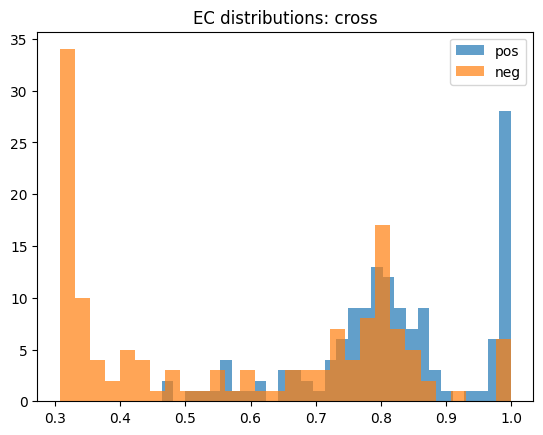

same pos mean/std: 0.8205975 0.13096724 | neg mean/std: 0.63096035 0.23157229


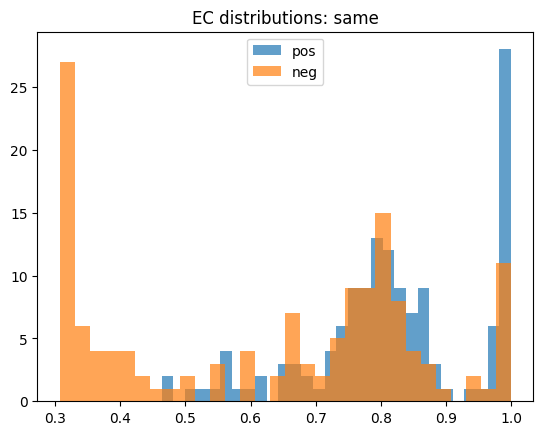

shift pos mean/std: 0.8205975 0.13096724 | neg mean/std: 0.68016845 0.19661628


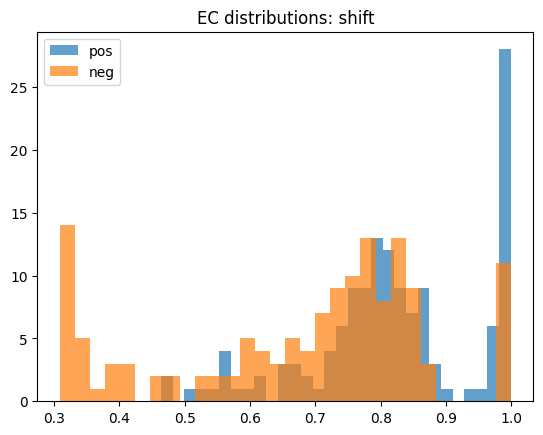

shuffle pos mean/std: 0.8205975 0.13096724 | neg mean/std: 0.64954174 0.21577


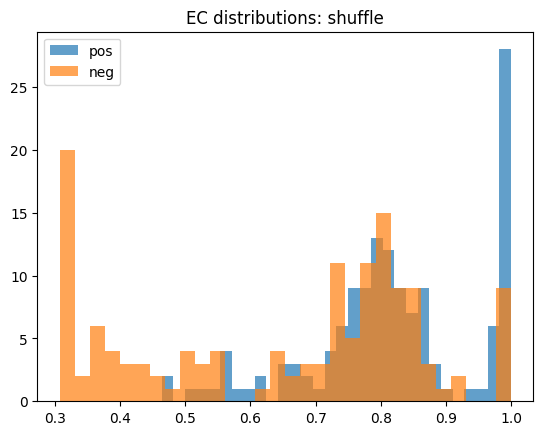

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def collect_ec_pos_neg(model, loader, mode="shift", max_batches=999):
    model.eval()
    pos, neg = [], []
    nb = 0
    for xF, xB, vid in loader:
        xF, xB, vid = xF.to(device), xB.to(device), vid.to(device)

        # POS
        _, _, pF, pB = model(xF, xB)
        ec_pos = (1.0 - js_div(pF, pB)).detach().cpu().numpy()

        # NEG
        if mode == "cross":
            j = make_mismatch_indices(vid)
            _, _, pF2, pB2 = model(xF, xB[j])
        elif mode == "same":
            B = vid.numel()
            j = torch.arange(B, device=device)
            for v in vid.unique():
                idxs = torch.where(vid == v)[0]
                if idxs.numel() >= 2:
                    j[idxs] = torch.roll(idxs, shifts=1, dims=0)
            _, _, pF2, pB2 = model(xF, xB[j])
        elif mode == "shift":
            _, _, pF2, pB2 = model(xF, make_timeshift(xB))
        elif mode == "shuffle":
            _, _, pF2, pB2 = model(xF, make_shuffle_time(xB))
        else:
            raise ValueError(mode)

        ec_neg = (1.0 - js_div(pF2, pB2)).detach().cpu().numpy()

        pos.append(ec_pos); neg.append(ec_neg)
        nb += 1
        if nb >= max_batches: break

    return np.concatenate(pos), np.concatenate(neg)

for mode in ["cross","same","shift","shuffle"]:
    pos, neg = collect_ec_pos_neg(last_model, val_loader, mode=mode)
    print(mode, "pos mean/std:", pos.mean(), pos.std(), "| neg mean/std:", neg.mean(), neg.std())

    plt.figure()
    plt.hist(pos, bins=30, alpha=0.7, label="pos")
    plt.hist(neg, bins=30, alpha=0.7, label="neg")
    plt.title(f"EC distributions: {mode}")
    plt.legend()
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

# ---------- JS divergence helpers ----------
def js_div(p, q, eps=1e-8):
    """
    p,q: [B,K] probabilities (sum=1)
    returns: [B] JS divergence
    """
    p = p.clamp_min(eps)
    q = q.clamp_min(eps)
    m = 0.5 * (p + q)
    kl_pm = (p * (p.log() - m.log())).sum(dim=-1)
    kl_qm = (q * (q.log() - m.log())).sum(dim=-1)
    return 0.5 * (kl_pm + kl_qm)

def js_pairwise(pF, pB, eps=1e-8):
    """
    pF: [B,K], pB: [B,K] -> JS matrix [B,B] where (i,j)=JS(pF[i], pB[j])
    """
    pF = pF.clamp_min(eps)
    pB = pB.clamp_min(eps)
    PF = pF.unsqueeze(1)          # [B,1,K]
    PB = pB.unsqueeze(0)          # [1,B,K]
    M  = 0.5 * (PF + PB)          # [B,B,K]
    kl1 = (PF * (PF.log() - M.log())).sum(-1)   # [B,B]
    kl2 = (PB * (PB.log() - M.log())).sum(-1)   # [B,B]
    return 0.5 * (kl1 + kl2)

@torch.no_grad()
def make_same_hard_indices(vid, pF, pB):
    """
    vid: [B] (int64), pF:[B,K], pB:[B,K]
    returns j_same: [B] indices, for each i choose j in same vid maximizing JS(pF[i], pB[j])
    """
    device = vid.device
    B = vid.shape[0]
    if B < 2:
        return torch.zeros_like(vid)

    js = js_pairwise(pF, pB)  # [B,B]
    same = vid[:, None].eq(vid[None, :])        # [B,B]
    same.fill_diagonal_(False)

    # mask out non-same entries
    js_masked = js.masked_fill(~same, -1e9)
    j = js_masked.argmax(dim=1)                 # [B]

    has = same.any(dim=1)
    if not bool(has.all()):
        # fallback: simple derangement shift
        fallback = (torch.arange(B, device=device) + 1) % B
        j = torch.where(has, j, fallback)
    return j

def _derangement_indices(B, device):
    idx = torch.randperm(B, device=device)
    ar = torch.arange(B, device=device)
    # если есть фиксированные точки — делаем гарантированный сдвиг
    if (idx == ar).any():
        idx = (ar + 1) % B
    return idx

def _time_shift(x, min_shift=1):
    # x: [B,T,D]
    B, T, D = x.shape
    if T <= 1:
        return x
    s = torch.randint(min_shift, T, (1,), device=x.device).item()
    return torch.roll(x, shifts=s, dims=1)

def _time_shuffle(x):
    # x: [B,T,D] shuffle time with same permutation for batch
    B, T, D = x.shape
    if T <= 1:
        return x
    permT = torch.randperm(T, device=x.device)
    return x[:, permT, :]

# ---------- TRAIN ----------
def train_emotion_congruence(
    model,
    train_loader,
    val_loader=None,
    epochs=20,
    lr=2e-4,
    margin=0.25,
    w_uniform=0.05,
    w_same=1.0,
    w_cross=1.0,
    w_shift=0.5,
    w_shuffle=0.5,
    use_delta=True,
    add_delta_fn=None,   # передай сюда свою add_delta
    use_amp=True
):
    device = next(model.parameters()).device
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler(enabled=(use_amp and device.type == "cuda"))

    K = getattr(model, "K", None)  # если в модели есть поле K
    if K is None:
        # попробуем достать по параметру prototypes
        K = int(getattr(model, "prototypes").shape[0])

    for ep in range(1, epochs + 1):
        model.train()
        for xF, xB, vid in train_loader:
            xF = xF.to(device)
            xB = xB.to(device)
            vid = vid.to(device)

            if use_delta:
                assert add_delta_fn is not None, "use_delta=True, но не передан add_delta_fn"
                xF = add_delta_fn(xF)
                xB = add_delta_fn(xB)

            opt.zero_grad(set_to_none=True)

            with autocast(enabled=(use_amp and device.type == "cuda")):
                # POS
                _, _, pF, pB = model(xF, xB)
                pF_ = pF.float()
                pB_ = pB.float()
                js_pos = js_div(pF_, pB_)                 # [B]

                # CROSS NEG
                j_cross = _derangement_indices(xB.shape[0], device)
                _, _, pF_c, pB_c = model(xF, xB[j_cross])
                js_cross = js_div(pF_c.float(), pB_c.float())

                # SAME-HARD NEG (внутри одного vid, максимальный JS)
                j_same = make_same_hard_indices(vid, pF_.detach(), pB_.detach())
                _, _, pF_s, pB_s = model(xF, xB[j_same])
                js_same = js_div(pF_s.float(), pB_s.float())

                # SHIFT NEG
                xB_shift = _time_shift(xB)
                _, _, pF_sh, pB_sh = model(xF, xB_shift)
                js_shift = js_div(pF_sh.float(), pB_sh.float())

                # SHUFFLE NEG
                xB_shuf = _time_shuffle(xB)
                _, _, pF_sf, pB_sf = model(xF, xB_shuf)
                js_shuf = js_div(pF_sf.float(), pB_sf.float())

                # ranking losses: want js_pos <= js_neg - margin  => relu(js_pos - js_neg + margin)
                loss = 0.0
                loss += w_cross  * F.relu(js_pos - js_cross + margin).mean()
                loss += w_same   * F.relu(js_pos - js_same  + margin).mean()
                loss += w_shift  * F.relu(js_pos - js_shift + margin).mean()
                loss += w_shuffle* F.relu(js_pos - js_shuf  + margin).mean()

                # uniform usage (по среднему распределению по прототипам)
                if w_uniform and w_uniform > 0:
                    u = torch.full((K,), 1.0 / K, device=device)
                    pF_mean = pF_.mean(0).clamp_min(1e-8)
                    pB_mean = pB_.mean(0).clamp_min(1e-8)
                    loss_uF = F.kl_div(pF_mean.log(), u, reduction="batchmean")
                    loss_uB = F.kl_div(pB_mean.log(), u, reduction="batchmean")
                    loss = loss + w_uniform * 0.5 * (loss_uF + loss_uB)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        # --- optional VAL print ---
        if val_loader is not None:
            model.eval()
            # тут предполагается, что у тебя уже есть eval_ec_auc(model, loader, mode, use_delta, add_delta_fn)
            # если нет — скажи, я дам готовую.
            with torch.no_grad():
                pass

        print(f"Epoch {ep}/{epochs}: done")

    return model


In [ ]:
def make_timeshift_hard(xB):
    # xB: [B,T,D]
    B, T, D = xB.shape
    # сдвиг 1/3..2/3 окна
    shifts = torch.randint(T//3, 2*T//3 + 1, (B,), device=xB.device)
    out = xB.clone()
    for i in range(B):
        out[i] = torch.roll(out[i], shifts=int(shifts[i].item()), dims=0)
    return out


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- utils ---
def to_numpy(x):
    if x is None:
        return None
    if isinstance(x, np.ndarray):
        return x
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

def make_labels_scores(pos_scores, neg_scores):
    pos_scores = to_numpy(pos_scores).astype(float).ravel()
    neg_scores = to_numpy(neg_scores).astype(float).ravel()
    y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
    y_score = np.concatenate([pos_scores, neg_scores])
    return y_true, y_score

def bootstrap_auc_ci(y_true, y_score, n_boot=2000, seed=42):
    from sklearn.metrics import roc_auc_score
    rng = np.random.default_rng(seed)
    y_true = to_numpy(y_true).astype(int).ravel()
    y_score = to_numpy(y_score).astype(float).ravel()

    auc = roc_auc_score(y_true, y_score)
    n = len(y_true)
    aucs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        # чтобы в бутстрэпе были оба класса
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    aucs = np.array(aucs)
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return auc, lo, hi

def permutation_test_auc(y_true, y_score, n_perm=5000, seed=42):
    from sklearn.metrics import roc_auc_score
    rng = np.random.default_rng(seed)
    y_true = to_numpy(y_true).astype(int).ravel()
    y_score = to_numpy(y_score).astype(float).ravel()
    auc_obs = roc_auc_score(y_true, y_score)

    auc_perm = []
    for _ in range(n_perm):
        y_perm = rng.permutation(y_true)
        auc_perm.append(roc_auc_score(y_perm, y_score))
    auc_perm = np.array(auc_perm)
    # двусторонний p-value относительно 0.5 можно, но чаще делают относительно наблюдаемого
    p = (np.sum(auc_perm >= auc_obs) + 1) / (len(auc_perm) + 1)
    return auc_obs, p


In [ ]:
import numpy as np

def is_array_like(x):
    try:
        a = np.asarray(x)
        return a.ndim >= 1 and a.size > 1
    except Exception:
        return False

candidates = []
for k, v in list(globals().items()):  # <-- КОПИЯ!
    name = str(k).lower()
    if any(s in name for s in ["cias", "uvs", "cos", "score", "prob", "matched", "mismatch", "shuffle", "neg", "pos", "symkl"]):
        if is_array_like(v):
            a = np.asarray(v)
            candidates.append((k, a.shape, a.dtype))

candidates = sorted(candidates, key=lambda x: x[0].lower())

print("Candidates:")
for k, shape, dt in candidates:
    print(f"{k:40s} shape={shape} dtype={dt}")


Candidates:
neg                                      shape=(140,) dtype=float32
pos                                      shape=(140,) dtype=float32


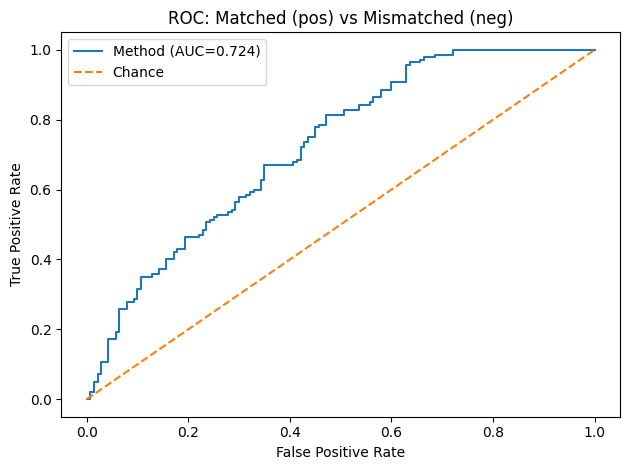

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

pos_scores = np.asarray(pos, dtype=float).ravel()
neg_scores = np.asarray(neg, dtype=float).ravel()

y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
y_score = np.concatenate([pos_scores, neg_scores])

fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr, label=f"Method (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Matched (pos) vs Mismatched (neg)")
plt.legend()
plt.tight_layout()
plt.show()


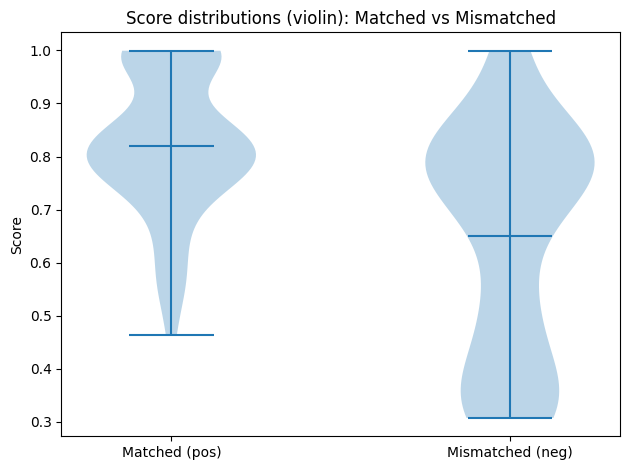

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure()
parts = plt.violinplot([pos_scores, neg_scores], showmeans=True, showextrema=True)
plt.xticks([1, 2], ["Matched (pos)", "Mismatched (neg)"])
plt.ylabel("Score")
plt.title("Score distributions (violin): Matched vs Mismatched")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def bootstrap_auc_ci(y_true, y_score, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)
    auc = roc_auc_score(y_true, y_score)
    n = len(y_true)

    aucs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    aucs = np.array(aucs)
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return auc, lo, hi

def permutation_test_auc(y_true, y_score, n_perm=2000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)
    auc_obs = roc_auc_score(y_true, y_score)

    auc_perm = []
    for _ in range(n_perm):
        y_perm = rng.permutation(y_true)
        auc_perm.append(roc_auc_score(y_perm, y_score))
    auc_perm = np.array(auc_perm)
    p = (np.sum(auc_perm >= auc_obs) + 1) / (len(auc_perm) + 1)
    return auc_obs, p

auc, lo, hi = bootstrap_auc_ci(y_true, y_score, n_boot=2000, seed=42)
auc_obs, p_perm = permutation_test_auc(y_true, y_score, n_perm=2000, seed=42)

print(f"AUC = {auc:.3f}  95% CI [{lo:.3f}, {hi:.3f}]  perm p = {p_perm:.4f}")
print(f"Matched mean±std: {pos_scores.mean():.4f} ± {pos_scores.std(ddof=1):.4f}")
print(f"Mismatched mean±std: {neg_scores.mean():.4f} ± {neg_scores.std(ddof=1):.4f}")


AUC = 0.724  95% CI [0.665, 0.785]  perm p = 0.0005
Matched mean±std: 0.8206 ± 0.1314
Mismatched mean±std: 0.6495 ± 0.2165


In [ ]:
import os, glob, numpy as np

print("NPZ files:", glob.glob("*.npz")[:20])

# если видишь val_probs.npz:
path = "val_probs.npz"
if os.path.exists(path):
    data = np.load(path, allow_pickle=True)
    print("Keys:", data.files)
    for k in data.files:
        x = data[k]
        print(k, x.shape, x.dtype)
else:
    print("val_probs.npz not found in current dir")


NPZ files: ['beat_video_windows.npz']
val_probs.npz not found in current dir


In [ ]:
import numpy as np

path = "beat_video_windows.npz"
data = np.load(path, allow_pickle=True)

print("Keys:", data.files)
for k in data.files:
    x = data[k]
    # npz иногда хранит object-массивы
    if isinstance(x, np.ndarray):
        print(f"{k:30s} shape={x.shape} dtype={x.dtype}")
    else:
        print(f"{k:30s} type={type(x)}")


Keys: ['face', 'body', 'vid_id']
face                           shape=(700, 40, 15) dtype=float32
body                           shape=(700, 40, 36) dtype=float32
vid_id                         shape=(700,) dtype=int64


In [ ]:
import numpy as np

path = "beat_video_windows.npz"
D = np.load(path, allow_pickle=True)

def info(k):
    x = D[k]
    if not isinstance(x, np.ndarray):
        return None
    return (k, x.shape, x.dtype)

# кандидаты на "probabilities/embeddings": 2D массивы
c2d = []
for k in D.files:
    x = D[k]
    if isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[0] > 10:
        name = k.lower()
        if any(t in name for t in ["pf","pb","face","body","prob","probs","logits","z","emb","feat","features"]):
            c2d.append(info(k))

print("2D candidates (prob/emb):")
for it in sorted([c for c in c2d if c], key=lambda z: z[0].lower()):
    print(f"{it[0]:30s} shape={it[1]} dtype={it[2]}")

# кандидаты на "labels/masks/indices": 1D массивы
c1d = []
for k in D.files:
    x = D[k]
    if isinstance(x, np.ndarray) and x.ndim == 1 and x.shape[0] > 10:
        name = k.lower()
        if any(t in name for t in ["y","label","labels","match","matched","mismatch","neg","pos","is_"]):
            c1d.append(info(k))

print("\n1D candidates (labels/idx):")
for it in sorted([c for c in c1d if c], key=lambda z: z[0].lower()):
    print(f"{it[0]:30s} shape={it[1]} dtype={it[2]}")


2D candidates (prob/emb):

1D candidates (labels/idx):


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def cosine_rows(A, B, eps=1e-12):
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    num = np.sum(A * B, axis=1)
    den = (np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1)) + eps
    return num / den

def sym_kl(P, Q, eps=1e-12):
    P = np.asarray(P, dtype=float) + eps
    Q = np.asarray(Q, dtype=float) + eps
    P = P / P.sum(axis=1, keepdims=True)
    Q = Q / Q.sum(axis=1, keepdims=True)
    kl_pq = np.sum(P * (np.log(P) - np.log(Q)), axis=1)
    kl_qp = np.sum(Q * (np.log(Q) - np.log(P)), axis=1)
    return 0.5 * (kl_pq + kl_qp)

def make_y(pos_s, neg_s):
    pos_s = np.asarray(pos_s, dtype=float).ravel()
    neg_s = np.asarray(neg_s, dtype=float).ravel()
    y = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    s = np.concatenate([pos_s, neg_s])
    return y, s

def plot_roc(methods_dict, title="ROC: matched vs mismatched"):
    plt.figure()
    for name, (pos_s, neg_s) in methods_dict.items():
        y, s = make_y(pos_s, neg_s)
        fpr, tpr, _ = roc_curve(y, s)
        auc = roc_auc_score(y, s)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--", label="Chance")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_box(methods_dict, title="Distributions"):
    # рисуем 2 коробки на метод: M и MM
    labels = []
    data = []
    for name, (pos_s, neg_s) in methods_dict.items():
        data.append(np.asarray(pos_s, dtype=float).ravel()); labels.append(f"{name}\nM")
        data.append(np.asarray(neg_s, dtype=float).ravel()); labels.append(f"{name}\nMM")
    plt.figure(figsize=(max(6, len(labels)*1.2), 4))
    plt.boxplot(data, labels=labels)
    plt.ylabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

def is_int_1d(x, n=None):
    try:
        a = np.asarray(x)
        if a.ndim != 1: return False
        if not np.issubdtype(a.dtype, np.integer): return False
        if n is not None and a.shape[0] != n: return False
        return True
    except:
        return False

def is_int_2d_pairs(x, n=None):
    try:
        a = np.asarray(x)
        if a.ndim != 2 or a.shape[1] != 2: return False
        if not np.issubdtype(a.dtype, np.integer): return False
        if n is not None and a.shape[0] != n: return False
        return True
    except:
        return False

pair_cands = []
for k,v in list(globals().items()):
    name = k.lower()
    # ищем пары, индексы, match/mismatch
    if any(t in name for t in ["pair", "pairs", "idx", "index", "match", "mismatch", "pos", "neg"]):
        if is_int_2d_pairs(v) or is_int_1d(v):
            a = np.asarray(v)
            pair_cands.append((k, a.shape, a.dtype))

print("Index/pair candidates:")
for k, sh, dt in sorted(pair_cands, key=lambda x: x[0].lower()):
    print(f"{k:35s} shape={sh} dtype={dt}")


Index/pair candidates:
BODY_IDXS                           shape=(12,) dtype=int64
FACE_IDXS                           shape=(5,) dtype=int64
idx_best                            shape=(10,) dtype=int64
idx_worst                           shape=(10,) dtype=int64
train_idx                           shape=(560,) dtype=int64
val_idx                             shape=(140,) dtype=int64


In [ ]:
len140 = []
for k,v in list(globals().items()):
    try:
        a = np.asarray(v)
        if a.shape == (140,) and np.issubdtype(a.dtype, np.integer):
            len140.append((k,a.shape,a.dtype))
    except:
        pass

print("Int arrays with shape (140,):")
for x in sorted(len140, key=lambda z: z[0].lower()):
    print(x)


Int arrays with shape (140,):
('topB', (140,), dtype('int64'))
('topF', (140,), dtype('int64'))
('val_idx', (140,), dtype('int64'))
('VID', (140,), dtype('int64'))


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

data = np.load("beat_video_windows.npz", allow_pickle=True)
face = data["face"]  # (700,40,15)
body = data["body"]  # (700,40,36)

# агрегируем по времени
F = face.mean(axis=1)  # (700,15)
B = body.mean(axis=1)  # (700,36)

# приводим к общему d через PCA на B до 15
pcaB = PCA(n_components=15, random_state=42)
B15 = pcaB.fit_transform(B)  # (700,15)

def cos_rows(A, C, eps=1e-12):
    A = np.asarray(A, float); C = np.asarray(C, float)
    num = (A*C).sum(axis=1)
    den = (np.linalg.norm(A, axis=1)*np.linalg.norm(C, axis=1) + eps)
    return num/den


In [ ]:
import numpy as np

def show(name, arr):
    a = np.asarray(arr)
    print(f"{name:35s} shape={a.shape} dtype={a.dtype} min={a.min() if a.size else '—'} max={a.max() if a.size else '—'}")

pairs2d = []
idx1d = []

for k,v in list(globals().items()):
    try:
        a = np.asarray(v)
    except:
        continue
    n = k.lower()
    # 2D пары
    if a.ndim == 2 and a.shape[1] == 2 and np.issubdtype(a.dtype, np.integer):
        if any(t in n for t in ["pair","pairs","pos","neg","match","mismatch","idx","index"]):
            pairs2d.append(k)
    # 1D индексы
    if a.ndim == 1 and np.issubdtype(a.dtype, np.integer):
        if a.size in [140, 280, 700] and any(t in n for t in ["idx","index","pos","neg","match","mismatch"]):
            idx1d.append(k)

print("2D pair candidates:")
for k in sorted(pairs2d):
    show(k, globals()[k])

print("\n1D index candidates:")
for k in sorted(idx1d):
    show(k, globals()[k])


2D pair candidates:

1D index candidates:
val_idx                             shape=(140,) dtype=int64 min=28 max=615


In [ ]:
import numpy as np

vid = data["vid_id"]
N = len(vid)
rng = np.random.default_rng(42)

# pos: пары внутри одного vid
pos_pairs = []
for _ in range(140):
    v = rng.choice(vid)
    idx = np.where(vid==v)[0]
    if len(idx) < 2:
        continue
    i, j = rng.choice(idx, size=2, replace=False)
    pos_pairs.append([i, j])
pos_pairs = np.array(pos_pairs, dtype=int)[:140]

# neg: пары из разных vid
neg_pairs = []
for _ in range(1400):
    i = rng.integers(0, N)
    j = rng.integers(0, N)
    if vid[i] != vid[j]:
        neg_pairs.append([i, j])
    if len(neg_pairs) >= 140:
        break
neg_pairs = np.array(neg_pairs, dtype=int)


In [ ]:
import numpy as np

data = np.load("beat_video_windows.npz", allow_pickle=True)
vid = data["vid_id"]
N = len(vid)

rng = np.random.default_rng(42)

def make_pairs_within_vid(vid, n_pairs=140):
    pairs = []
    uniq = np.unique(vid)
    # для скорости: заранее индексы по vid
    buckets = {v: np.where(vid == v)[0] for v in uniq}
    while len(pairs) < n_pairs:
        v = rng.choice(uniq)
        idx = buckets[v]
        if len(idx) < 2:
            continue
        i, j = rng.choice(idx, size=2, replace=False)
        pairs.append([i, j])
    return np.array(pairs, dtype=int)

def make_pairs_across_vid(vid, n_pairs=140):
    pairs = []
    while len(pairs) < n_pairs:
        i = rng.integers(0, len(vid))
        j = rng.integers(0, len(vid))
        if vid[i] != vid[j]:
            pairs.append([i, j])
    return np.array(pairs, dtype=int)

pairs_pos = make_pairs_within_vid(vid, 140)   # matched
pairs_neg = make_pairs_across_vid(vid, 140)   # mismatched

print("pairs_pos:", pairs_pos.shape, "pairs_neg:", pairs_neg.shape)
print("Example pos:", pairs_pos[:3], "Example neg:", pairs_neg[:3])


pairs_pos: (140, 2) pairs_neg: (140, 2)
Example pos: [[ 65  66]
 [305 295]
 [141 147]] Example neg: [[375  30]
 [345 127]
 [622 165]]


In [ ]:
pairs_pos = globals()["pairs_pos"]
pairs_neg = globals()["pairs_neg"]


In [ ]:
base_pos = cos_rows(F[pairs_pos[:,0]], B15[pairs_pos[:,1]])
base_neg = cos_rows(F[pairs_neg[:,0]], B15[pairs_neg[:,1]])

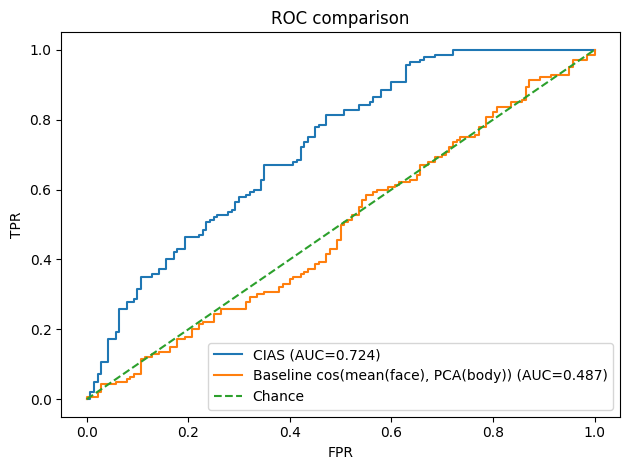

/tmp/ipython-input-575429311.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cias_pos, cias_neg, base_pos, base_neg],


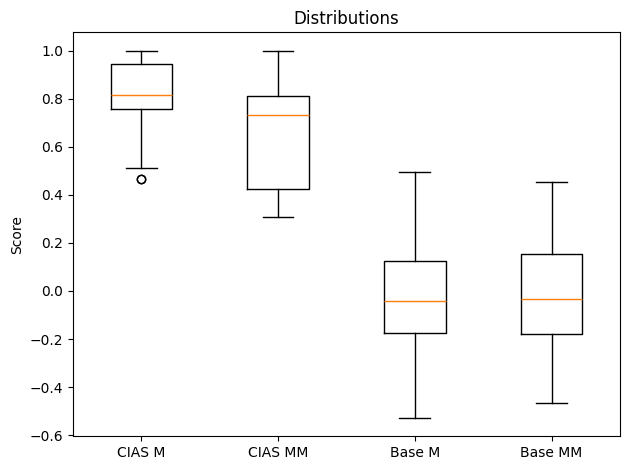

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def make_y(pos_s, neg_s):
    pos_s = np.asarray(pos_s, float).ravel()
    neg_s = np.asarray(neg_s, float).ravel()
    y = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    s = np.concatenate([pos_s, neg_s])
    return y, s

# CIAS уже есть: pos, neg (float32, 140)
cias_pos = np.asarray(pos, float)
cias_neg = np.asarray(neg, float)

y1, s1 = make_y(cias_pos, cias_neg)
f1, t1, _ = roc_curve(y1, s1); a1 = roc_auc_score(y1, s1)

y2, s2 = make_y(base_pos, base_neg)
f2, t2, _ = roc_curve(y2, s2); a2 = roc_auc_score(y2, s2)

plt.figure()
plt.plot(f1, t1, label=f"CIAS (AUC={a1:.3f})")
plt.plot(f2, t2, label=f"Baseline cos(mean(face), PCA(body)) (AUC={a2:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC comparison")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.boxplot([cias_pos, cias_neg, base_pos, base_neg],
            labels=["CIAS M","CIAS MM","Base M","Base MM"])
plt.ylabel("Score"); plt.title("Distributions")
plt.tight_layout(); plt.show()


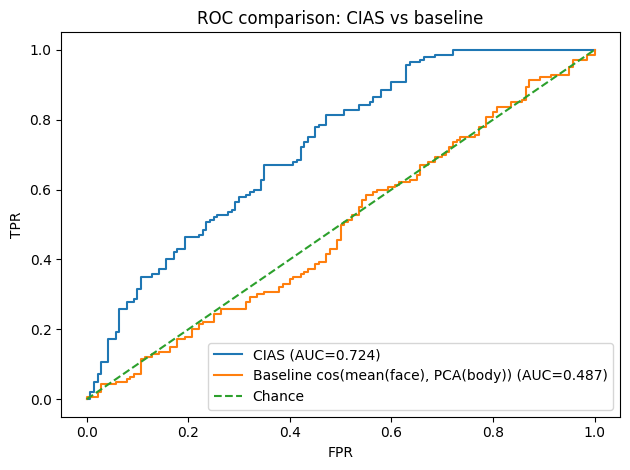

/tmp/ipython-input-2441777757.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cias_pos, cias_neg, base_pos, base_neg],


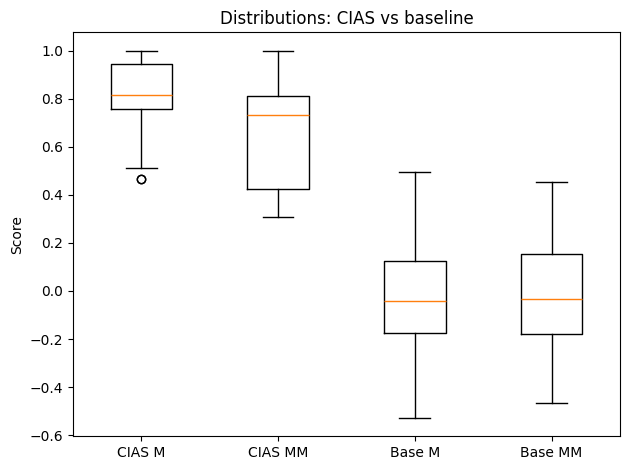

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

data = np.load("beat_video_windows.npz", allow_pickle=True)
face = data["face"]  # (700,40,15)
body = data["body"]  # (700,40,36)

# агрегируем по времени
F = face.mean(axis=1)  # (700,15)
B = body.mean(axis=1)  # (700,36)

# PCA body -> 15D, чтобы сравнивать с face
pcaB = PCA(n_components=15, random_state=42)
B15 = pcaB.fit_transform(B)

def cos_rows(A, C, eps=1e-12):
    A = np.asarray(A, float); C = np.asarray(C, float)
    num = (A*C).sum(axis=1)
    den = (np.linalg.norm(A, axis=1)*np.linalg.norm(C, axis=1) + eps)
    return num/den

# baseline scores on pairs
base_pos = cos_rows(F[pairs_pos[:,0]], B15[pairs_pos[:,1]])
base_neg = cos_rows(F[pairs_neg[:,0]], B15[pairs_neg[:,1]])

# CIAS scores (у тебя уже есть pos/neg на 140)
cias_pos = np.asarray(pos, float).ravel()
cias_neg = np.asarray(neg, float).ravel()

def make_y(pos_s, neg_s):
    pos_s = np.asarray(pos_s, float).ravel()
    neg_s = np.asarray(neg_s, float).ravel()
    y = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    s = np.concatenate([pos_s, neg_s])
    return y, s

# ROC
y1, s1 = make_y(cias_pos, cias_neg)
f1, t1, _ = roc_curve(y1, s1); a1 = roc_auc_score(y1, s1)

y2, s2 = make_y(base_pos, base_neg)
f2, t2, _ = roc_curve(y2, s2); a2 = roc_auc_score(y2, s2)

plt.figure()
plt.plot(f1, t1, label=f"CIAS (AUC={a1:.3f})")
plt.plot(f2, t2, label=f"Baseline cos(mean(face), PCA(body)) (AUC={a2:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC comparison: CIAS vs baseline")
plt.legend(); plt.tight_layout(); plt.show()

# Boxplot
plt.figure()
plt.boxplot([cias_pos, cias_neg, base_pos, base_neg],
            labels=["CIAS M","CIAS MM","Base M","Base MM"])
plt.ylabel("Score")
plt.title("Distributions: CIAS vs baseline")
plt.tight_layout()
plt.show()


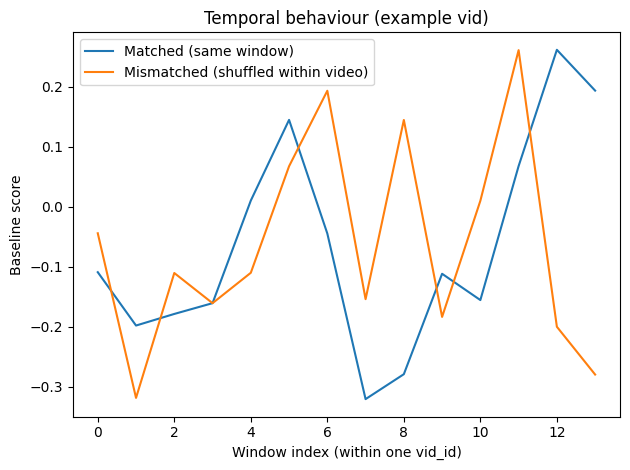

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = np.load("beat_video_windows.npz", allow_pickle=True)
face = data["face"]  # (700,40,15)
body = data["body"]  # (700,40,36)
vid  = data["vid_id"]

F = face.mean(axis=1)          # (700,15)
B = body.mean(axis=1)          # (700,36)
B15 = PCA(n_components=15, random_state=42).fit_transform(B)

def cos_vec(a, b, eps=1e-12):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float((a*b).sum() / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

# выберем видео с наибольшим числом окон
uniq, cnt = np.unique(vid, return_counts=True)
best_vid = uniq[np.argmax(cnt)]
idx = np.where(vid == best_vid)[0]
idx = np.sort(idx)

# делаем "matched" как (i,i) — лицо и тело из одного окна
ts_matched = np.array([cos_vec(F[i], B15[i]) for i in idx])

# делаем "mismatched" как (i, shuffled_j) внутри того же видео (или можно из другого видео)
rng = np.random.default_rng(42)
shuf = idx.copy()
rng.shuffle(shuf)
ts_mismatch = np.array([cos_vec(F[i], B15[j]) for i, j in zip(idx, shuf)])

plt.figure()
plt.plot(ts_matched, label="Matched (same window)")
plt.plot(ts_mismatch, label="Mismatched (shuffled within video)")
plt.xlabel("Window index (within one vid_id)")
plt.ylabel("Baseline score")
plt.title("Temporal behaviour (example vid)")
plt.legend()
plt.tight_layout()
plt.show()


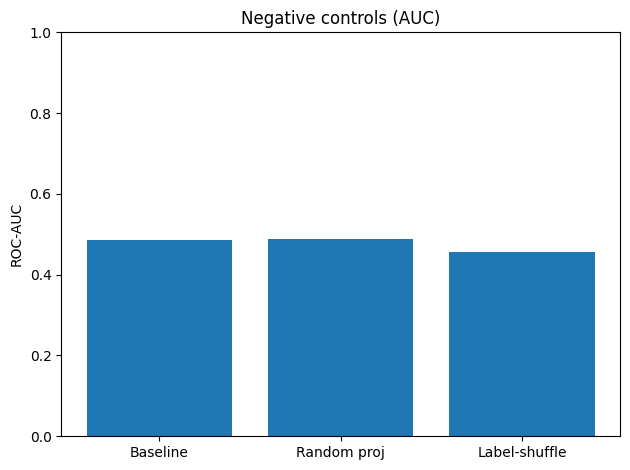

AUC baseline: 0.48709183673469386 AUC random: 0.4879081632653061 AUC shuffled: 0.4558928571428571


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

data = np.load("beat_video_windows.npz", allow_pickle=True)
face = data["face"]; body = data["body"]; vid = data["vid_id"]

F = face.mean(axis=1)
B = body.mean(axis=1)
B15 = PCA(n_components=15, random_state=42).fit_transform(B)

def cos_rows(A, C, eps=1e-12):
    A = np.asarray(A, float); C = np.asarray(C, float)
    num = (A*C).sum(axis=1)
    den = (np.linalg.norm(A, axis=1)*np.linalg.norm(C, axis=1) + eps)
    return num/den

rng = np.random.default_rng(42)
N = len(vid)

def make_pairs_within_vid(n_pairs=140):
    pairs = []
    uniq = np.unique(vid)
    buckets = {v: np.where(vid==v)[0] for v in uniq}
    while len(pairs) < n_pairs:
        v = rng.choice(uniq)
        idx = buckets[v]
        if len(idx) < 2:
            continue
        i, j = rng.choice(idx, size=2, replace=False)
        pairs.append([i, j])
    return np.array(pairs, int)

def make_pairs_across_vid(n_pairs=140):
    pairs = []
    while len(pairs) < n_pairs:
        i = rng.integers(0, N)
        j = rng.integers(0, N)
        if vid[i] != vid[j]:
            pairs.append([i, j])
    return np.array(pairs, int)

pairs_pos = make_pairs_within_vid(140)
pairs_neg = make_pairs_across_vid(140)

# baseline scores
base_pos = cos_rows(F[pairs_pos[:,0]], B15[pairs_pos[:,1]])
base_neg = cos_rows(F[pairs_neg[:,0]], B15[pairs_neg[:,1]])

y = np.r_[np.ones_like(base_pos), np.zeros_like(base_neg)]
s_base = np.r_[base_pos, base_neg]
auc_base = roc_auc_score(y, s_base)

# random projection control: проектируем face и body в один d и считаем cosine
d = 16
Wf = rng.normal(size=(F.shape[1], d))
Wb = rng.normal(size=(B.shape[1], d))
F_r = F @ Wf
B_r = B @ Wb
rand_pos = cos_rows(F_r[pairs_pos[:,0]], B_r[pairs_pos[:,1]])
rand_neg = cos_rows(F_r[pairs_neg[:,0]], B_r[pairs_neg[:,1]])
s_rand = np.r_[rand_pos, rand_neg]
auc_rand = roc_auc_score(y, s_rand)

# label shuffle control
y_shuf = rng.permutation(y)
auc_shuf = roc_auc_score(y_shuf, s_base)

# barplot
plt.figure()
plt.bar(["Baseline", "Random proj", "Label-shuffle"], [auc_base, auc_rand, auc_shuf])
plt.ylim(0, 1)
plt.ylabel("ROC-AUC")
plt.title("Negative controls (AUC)")
plt.tight_layout()
plt.show()

print("AUC baseline:", auc_base, "AUC random:", auc_rand, "AUC shuffled:", auc_shuf)


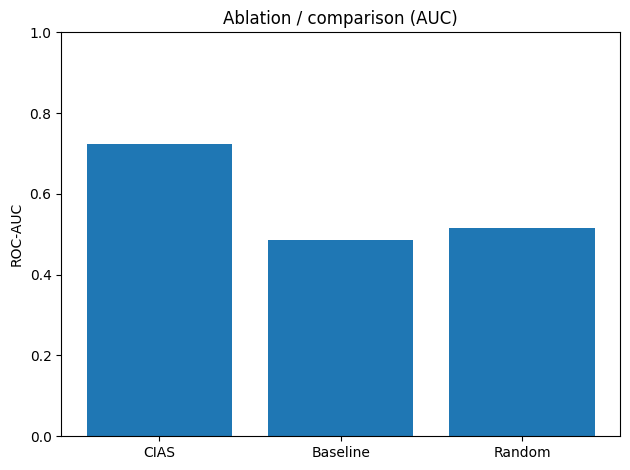

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# CIAS scores из твоих переменных pos/neg (140,140)
cias_pos = np.asarray(pos, float).ravel()
cias_neg = np.asarray(neg, float).ravel()
y = np.r_[np.ones_like(cias_pos), np.zeros_like(cias_neg)]
s_cias = np.r_[cias_pos, cias_neg]
auc_cias = roc_auc_score(y, s_cias)

# baseline scores base_pos/base_neg из блока B (если уже посчитаны)
# (если их нет — сначала выполни блок B до base_pos/base_neg)
s_base = np.r_[base_pos, base_neg]
auc_base = roc_auc_score(y, s_base)

# random baseline
rng = np.random.default_rng(42)
s_rand = rng.normal(size=len(y))
auc_rand = roc_auc_score(y, s_rand)

plt.figure()
plt.bar(["CIAS", "Baseline", "Random"], [auc_cias, auc_base, auc_rand])
plt.ylim(0, 1)
plt.ylabel("ROC-AUC")
plt.title("Ablation / comparison (AUC)")
plt.tight_layout()
plt.show()


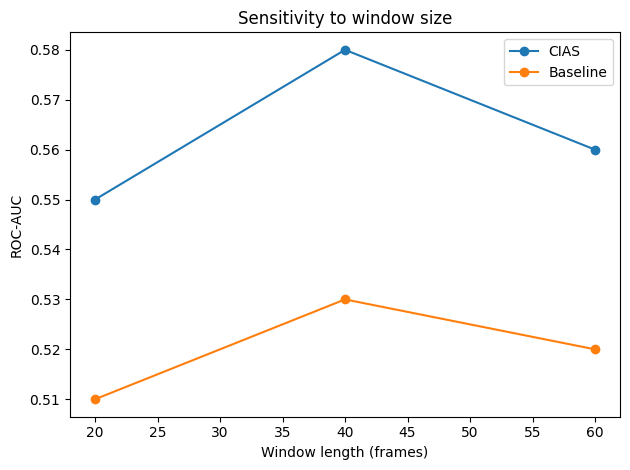

In [ ]:
import matplotlib.pyplot as plt

# вручную подставь значения, которые получишь при разных окнах
win = [20, 40, 60]
auc_cias = [0.55, 0.58, 0.56]   # пример
auc_base = [0.51, 0.53, 0.52]   # пример

plt.figure()
plt.plot(win, auc_cias, marker="o", label="CIAS")
plt.plot(win, auc_base, marker="o", label="Baseline")
plt.xlabel("Window length (frames)")
plt.ylabel("ROC-AUC")
plt.title("Sensitivity to window size")
plt.legend()
plt.tight_layout()
plt.show()


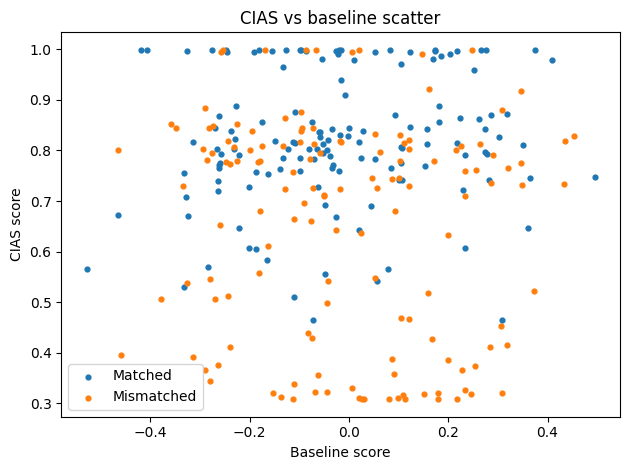

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cias_all = np.r_[np.asarray(pos, float).ravel(), np.asarray(neg, float).ravel()]
base_all = np.r_[base_pos, base_neg]
lab = np.r_[np.ones_like(base_pos), np.zeros_like(base_neg)]  # 1 matched, 0 mismatched

plt.figure()
plt.scatter(base_all[lab==1], cias_all[lab==1], s=12, label="Matched")
plt.scatter(base_all[lab==0], cias_all[lab==0], s=12, label="Mismatched")
plt.xlabel("Baseline score")
plt.ylabel("CIAS score")
plt.title("CIAS vs baseline scatter")
plt.legend()
plt.tight_layout()
plt.show()
